In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from sklearn.preprocessing import MinMaxScaler
import json

from utils import *

- [Introduction](#introduction)
  - [Project description](#project-description)
  - [Datasets description](#datasets-description)
  - [Preprocessing description](#preprocessing-description)
- [Exploration](#exploration)
  - [Genres](#genres)
  - [Actors](#actors)
  - [Runtime](#runtime)
  - [Release Date](#release-date)
  - [Countries](#countries)
  - [Tropes](#tropes)
- [Conclusion](#conclusion)

# Introduction

### Project description

In this project, we will explore the film reviews from amateurs and professionals. We will try to find the receipt to have a film that appeals equally to these audiences, and what are the parameters that can influence better appreciation by one audience rather than another.

### Datasets description
From the previous milestone, we have prepared an augmented database `cmu_movies_augmented`. The dataset is prepared from:

- **Characters Dataset** (`character.metadata.tsv`): Contains detailed metadata on movie characters and the actors portraying them. Key attributes include Wikipedia and Freebase IDs, movie release dates, character names, actor birthdates, genders, heights, ethnicities, and ages at the time of movie release.

- **Movies Dataset** (`movie.metadata.tsv`) Includes comprehensive information about movies. It features data such as Wikipedia and Freebase IDs, movie names, release dates, box office revenues, runtimes, languages, countries, and genres.

- **Plot Summaries Dataset** (`plot_summaries.text`): Offers a concise summary of movie plots, linked to movies through Wikipedia movie IDs.



#### External datasets 

We also use external datasets to enrich our data. 

1. **IMDb User Ratings** (`title.ratings.tsv`)

This dataset, sourced from [IMDb](https://datasets.imdbws.com), includes user ratings and the number of votes for each movie. It's a valuable asset for understanding public reception and popularity of the films in our dataset. It includes:
- `imdb_id`: The IMDb ID of the movie.
- `averageRating`: The mean user rating for each movie.
- `numVotes`: Total count of user votes each movie received.

2. **Critics Reviews and Ratings** (`metacritic_reviews.csv`)

We scraped data from [Metacritic](https://metacritic.com) to gather critics' reviews and ratings using the data collection methodology describe [here](#data-collection-methodology). This dataset gives us insights into the critical reception of the movies. It includes:
- `metacritic_id`: The Metacritic ID of the movie.
- `metacritic_rating`: The mean critic rating for each movie.
- `metascore`: An aggregate score representing the critical reception of a movie.
- `publisher`: The source of the critical review.
- `author`: The critic who authored the review.

3. **Awards and Nominations** (`imdb_awards.csv`)

This dataset, scraped from [IMDb](https://imdb.com), comprises information about the awards and nominations each movie received. It helps us analyze the correlation between critical acclaim, awards, and other factors like popularity and ratings. It includes:
- `imdb_id`: The IMDb ID of the movie.
- `num_wins`: The number of awards the movie won.
- `num_nominations`: The number of nominations the movie received.


#### Preprocessing description 

To prepare the dataset `cmu_movies`, we have fix theses points:

- The movies with release date in the future are removed 
- `release_date_datetime` colum has been added. This is a datetime version of the `release_date` column.
- The movies with non coherant runtime (0min or bigger than 500 minutes) are removed

Then the `cmu_movies_augmented` has been prepared. The 6 columns: `metacritic_id`,`imdb_rating`,`imdb_votes`,`metascore`,`count_nomination`,`count_award` has been added with the information from external dataset:
- `metacritic_id`: the id of the movie on Metacritic
- `imdb_rating`: the rating of the movie on IMDB
- `imdb_votes`: the number of votes on IMDB
- `metascore`: the metascore of the movie on Metacritic
- `count_nomination`: the number of nominations of the movie on IMDB
- `count_award`: the number of awards of the movie on IMDB


In [3]:
data = pd.read_csv('data/processed/cmu_movies_augmented.csv')

As we are interested in comparing the way movies are perceived by the public and by the critics, we will create 3 columns: `imdb_rating_scaled` `rating_difference` and `rating_ratio`:
- `imdb_rating_scaled`: the IMDB rating scaled to the same range as the metascore
- `rating_difference`: the difference between the metascore and the scaled IMDB rating
- `rating_ratio`: the ratio between the scaled IMDB rating and the metascore

In [4]:
data['imdb_rating_scaled'] = data['imdb_rating'] * 10
data['rating_difference'] = data['metascore'] - data['imdb_rating_scaled']
data['rating_ratio'] = data['imdb_rating_scaled'] / data['metascore']

print(f'Total movies: {len(data)}')
data.dropna(subset=['rating_difference'], inplace=True)
print(f'Total movies with rating_difference: {len(data)}')

Total movies: 8529
Total movies with rating_difference: 7770


In [75]:
#JSON export for website
#data[['imdb_id', 'imdb_rating_scaled', 'metascore', 'rating_difference', 'name']].to_json('website/public/data/playground-movies.json', orient='records')

### First look at `rating_difference`

We initiate the creation of a scatter plot juxtaposing IMDb user ratings against Metascore values and simultaneously visualize the distribution of the `rating_difference`. We can also print the mean and median of `rating_difference`.

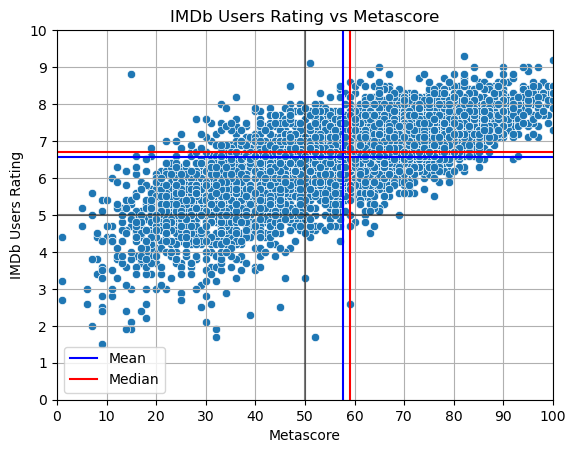

In [5]:
# Plot IMDb Users Rating vs Metascore in a scatter plot
sns.scatterplot(x="metascore", y="imdb_rating", data=data)
plt.title("IMDb Users Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

# plot center lines
plt.axhline(y=5, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=50, color='k', linestyle='-', alpha=0.5)

# plot mean lines
plt.axhline(y=data['imdb_rating'].mean(), color='b', linestyle='-')
plt.axvline(x=data['metascore'].mean(), color='b', linestyle='-')

# plot median lines
plt.axhline(y=data['imdb_rating'].median(), color='r', linestyle='-')
plt.axvline(x=data['metascore'].median(), color='r', linestyle='-')

# Add legend
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
plt.legend(handles=[blue_line, red_line])

plt.show()

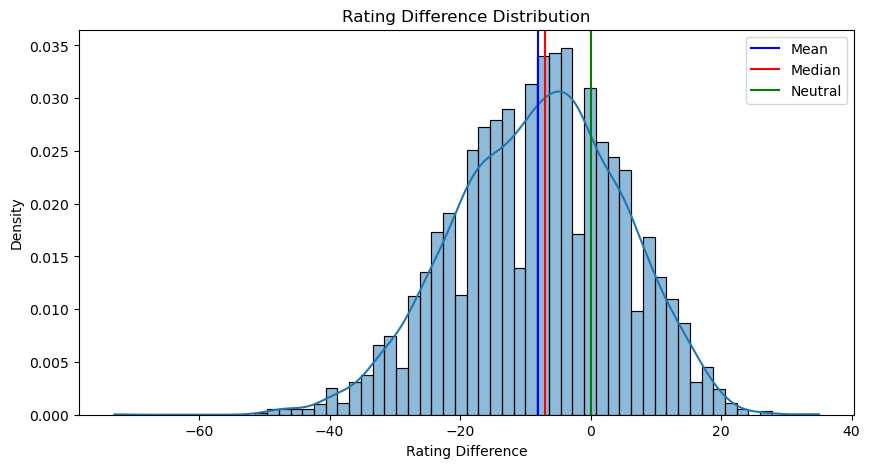

In [78]:
# Plot the mean and median and neutral rating difference
plt.figure(figsize=(10,5))
sns.histplot(data['rating_difference'], kde=True, stat='density', alpha=0.5)
plt.axvline(data['rating_difference'].mean(), color='b')
plt.axvline(data['rating_difference'].median(), color='r')
plt.axvline(0, color='g')
plt.xlabel('Rating Difference')
plt.ylabel('Density')
plt.title('Rating Difference Distribution')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

In [77]:
#Print the mean and median rating difference
print(f'Mean rating difference: {data["rating_difference"].mean()}')
print(f'Median rating difference: {data["rating_difference"].median()}')

Mean rating difference: -8.038996138996138
Median rating difference: -7.0


With this first exploration, we have found a difference between the metascore and IMDb ratings. It appears that IMDb users tend to assign higher ratings to movies compared to assessments from professional critics.

We can also plot the distribution of `rating_ratio`. 

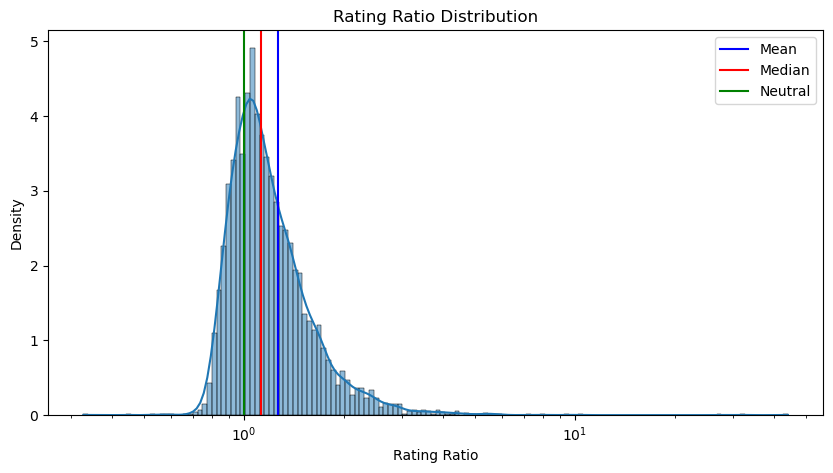

In [79]:
# Plot the mean and median and neutral rating ratio
plt.figure(figsize=(10,5))
sns.histplot(data['rating_ratio'], kde=True, stat='density', alpha=0.5, log_scale=True)
plt.axvline(data['rating_ratio'].mean(), color='b')
plt.axvline(data['rating_ratio'].median(), color='r')
plt.axvline(1, color='g')
plt.xlabel('Rating Ratio')
plt.ylabel('Density')
plt.title('Rating Ratio Distribution')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

The `rating_ratio` distribution shows the same difference between the two ratings. In the following, we will only use `rating_difference` for our analysis.

In the following sections, we'll try to explain the factors that can influence this rating difference. We will explore theses parameters:
- Genres
- Actors
- Runtime
- Release Date
- Countries 
- Tropes
- Languages
- Awards

# Exploration

## Genres

The analysis of the `genres` begins  with specific preprocessing steps, allowing to explode and retrieve the genres of each movie. This is done using the `process_genres()` function, which returns a dataframe with an additional column `genre` containing the genre of each movie. When a movie has multiple genres, it is assigned to multiple row.

In [5]:
df_genres = process_genres(data)
print(f"Movies with genres value: {len(df_genres['freebase_id'].unique())}/{len(data['freebase_id'].unique())}")

Movies with genres value: 7770/7770


### Basic exploration


Top 15:


,genres,rating_difference,number_of_movies,sem
281,Star vehicle,16.000000,2,5.000000
47,British New Wave,15.000000,2,6.000000
267,Silent film,14.545455,11,1.208783
237,Propaganda film,9.333333,3,5.206833
40,Black-and-white,7.275862,145,0.838232
204,Mumblecore,6.666667,9,2.629956
310,World History,6.000000,2,8.000000
255,Samurai cinema,5.200000,10,3.158058
116,Essay Film,4.857143,7,3.887885
233,Pre-Code,4.333333,6,4.240021



Bottom 15:


,genres,rating_difference,number_of_movies,sem
203,Movies About Gladiators,-15.000000,2,3.000000
248,Road-Horror,-15.076923,13,3.685491
269,Slasher,-15.354037,161,1.032034
48,Buddy cop,-15.500000,10,4.874537
11,Albino bias,-16.000000,7,3.823486
268,Slapstick,-16.892617,149,0.963987
1,Acid western,-17.333333,3,7.535103
170,Horse racing,-18.333333,3,8.353309
293,Sword and sorcery,-18.538462,13,2.856875
174,Indian Western,-18.666667,3,8.743251


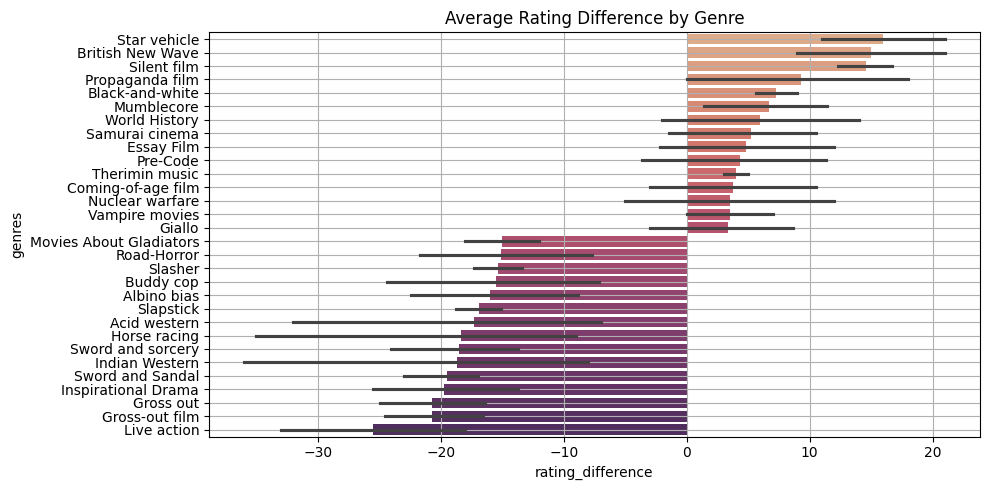

In [6]:
# Group by genre and calculate average rating_difference for each genre
genre_scores = df_genres.groupby('genres')['rating_difference'].agg(['mean', 'count', 'sem']).reset_index().rename(columns={'mean': 'rating_difference', 'count': 'number_of_movies'})

# Dropping rows where genre is NaN or Metascore is NaN
genre_scores = genre_scores.dropna()

# Sorting the genres by average rating_difference
genre_scores_sorted = genre_scores.sort_values(by='rating_difference', ascending=False)

if len(genre_scores_sorted) > 30:
    print('\nTop 15:')
    display(genre_scores_sorted.head(15))

    print('\nBottom 15:')
    display(genre_scores_sorted.tail(15))

    plot_results(df_genres.loc[df_genres['genres'].isin(pd.concat([genre_scores_sorted.head(15)['genres'], genre_scores_sorted.tail(15)['genres']]))], 'genres', 'rating_difference', 'Average Rating Difference by Genre')

else:
    display(genre_scores_sorted)
    plot_results(genre_scores_sorted, 'genres', 'rating_difference', 'Average Rating Difference by Genre')

Looking at the plot, we can see that the genres having the biggest difference are quite odd. Indeed, amongst genres that could be expected, such as `Silent film` or `Black and white`, we can see weird subgenres such as `Theremin music` or `Acid western`. The confidence interval also seems quite large, which is not surprising given the small number of movies some small genres have. The overall conclusion is that without further processing, the genres are not very useful and a lot of insightful informations are drowned in the noise. This plot can't really be used to assess if a genre is more popular than another.

In [11]:
#export_json(genre_scores_sorted, 'website/public/data/genres-1.json')

### Hotencoding

In [7]:
# Hot encode the genres
one_hot_movies_genres, one_hot_movies_genres_columns  = hotencode(df_genres, 'genres', id_column='freebase_id', prefix='onehot-genre')

# Add the rating_difference column
one_hot_movies_genres = one_hot_movies_genres.merge(data[['freebase_id', 'rating_difference']].drop_duplicates(), on='freebase_id')

print(one_hot_movies_genres.shape)

(7770, 316)


### Pearson Correlation

Significant results: 97/314

Top 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Genre
onehot-genre_World cinema,0.172514,5.686407e-53,0.150857,0.194006,onehot-genre_World cinema,World cinema,1240,World cinema
onehot-genre_Drama,0.169811,2.343363e-51,0.148134,0.191324,onehot-genre_Drama,Drama,4331,Drama
onehot-genre_Black-and-white,0.166375,2.420414e-49,0.144674,0.187915,onehot-genre_Black-and-white,Black-and-white,145,Black-and-white
onehot-genre_Art film,0.094680,6.102339e-17,0.072597,0.116670,onehot-genre_Art film,Art film,103,Art film
onehot-genre_Documentary,0.077321,8.804232e-12,0.055181,0.099386,onehot-genre_Documentary,Documentary,659,Documentary
onehot-genre_Film noir,0.076741,1.257547e-11,0.054599,0.098808,onehot-genre_Film noir,Film noir,62,Film noir
onehot-genre_New Hollywood,0.073733,7.654204e-11,0.051582,0.095812,onehot-genre_New Hollywood,New Hollywood,59,New Hollywood
onehot-genre_Biography,0.070240,5.712804e-10,0.048080,0.092332,onehot-genre_Biography,Biography,417,Biography
onehot-genre_Silent film,0.066990,3.405795e-09,0.044822,0.089093,onehot-genre_Silent film,Silent film,11,Silent film
onehot-genre_History,0.064335,1.379554e-08,0.042159,0.086447,onehot-genre_History,History,228,History



Bottom 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Genre
onehot-genre_Gross out,-0.072547,1.530600e-10,-0.094630,-0.050393,onehot-genre_Gross out,Gross out,41,Gross out
onehot-genre_Gross-out film,-0.072547,1.530600e-10,-0.094630,-0.050393,onehot-genre_Gross-out film,Gross-out film,41,Gross-out film
onehot-genre_Horror,-0.082430,3.407698e-13,-0.104474,-0.060305,onehot-genre_Horror,Horror,721,Horror
onehot-genre_Slasher,-0.083825,1.353157e-13,-0.105864,-0.061705,onehot-genre_Slasher,Slasher,161,Slasher
onehot-genre_Teen,-0.088492,5.519274e-15,-0.110511,-0.066387,onehot-genre_Teen,Teen,314,Teen
onehot-genre_Comedy,-0.088898,4.146261e-15,-0.110914,-0.066794,onehot-genre_Comedy,Comedy,2667,Comedy
onehot-genre_Thriller,-0.089570,2.573478e-15,-0.111583,-0.067469,onehot-genre_Thriller,Thriller,1928,Thriller
onehot-genre_Slapstick,-0.097525,6.945748e-18,-0.119502,-0.075453,onehot-genre_Slapstick,Slapstick,149,Slapstick
onehot-genre_Action/Adventure,-0.114463,4.444883e-24,-0.136352,-0.092463,onehot-genre_Action/Adventure,Action/Adventure,1018,Action/Adventure
onehot-genre_Action,-0.141135,7.339506e-36,-0.162860,-0.119274,onehot-genre_Action,Action,1395,Action


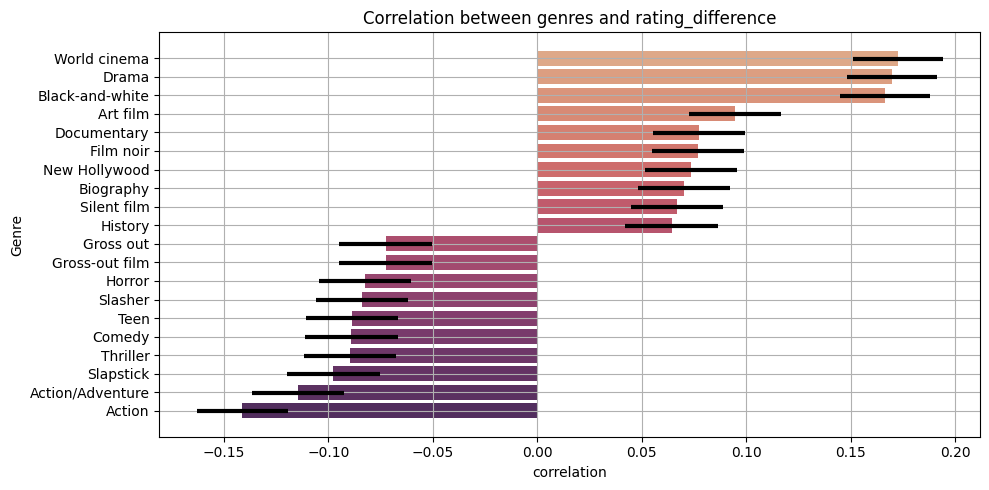

In [8]:
def map_genres_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_genres[df_genres['genres'] == x]))

    return df

genres_pearsonr_results, genres_pearsonr_significant  = study_pearson(
    one_hot_movies_genres,
    one_hot_movies_genres_columns,
    'rating_difference',
    colname='Genre',
    threshold=0.05,
    print_results=True,
    map_columns_name=map_genres_columns,
    plot_barplot=True,
    title="Correlation between genres and rating_difference",
    limit_tops=20
)

In [14]:
#export_json(genres_pearsonr_results, 'website/public/data/genres-2.json')

### Basic OLS

Dep. Variable:,rating_difference,R-squared:,0.191
Model:,OLS,Adj. R-squared:,0.157
Method:,Least Squares,F-statistic:,5.639
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,2.54e-174
Time:,23:02:58,Log-Likelihood:,-29944.
No. Observations:,7770,AIC:,6.052e+04
Df Residuals:,7456,BIC:,6.270e+04
Df Model:,313,,
Covariance Type:,nonrobust,,


Omnibus:,59.991,Durbin-Watson:,1.941
Prob(Omnibus):,0.000,Jarque-Bera (JB):,61.948
Skew:,-0.203,Prob(JB):,3.53e-14
Kurtosis:,3.164,Cond. No.,2.25e+15




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.191423,0.15748,9.094414,130.287108
baseline,0.0,0.0,10.266286,161.131427
improvement,inf,inf,-11.41%,-19.14%


Significant results: 66/314

Top 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Genre
47,onehot-genre_Point of view shot,26.7653,0.036,1.783,51.748,Point of view shot,1,Point of view shot
21,onehot-genre_Ealing Comedies,26.2150,0.025,3.311,49.119,Ealing Comedies,1,Ealing Comedies
10,onehot-genre_Cavalry Film,24.1521,0.040,1.096,47.208,Cavalry Film,1,Cavalry Film
30,onehot-genre_Gay Interest,18.7654,0.025,2.355,35.175,Gay Interest,89,Gay Interest
31,onehot-genre_Giallo,18.2467,0.008,4.760,31.733,Giallo,3,Giallo
43,onehot-genre_Mumblecore,14.4472,0.000,6.730,22.164,Mumblecore,9,Mumblecore
24,onehot-genre_Experimental film,12.8705,0.004,4.103,21.638,Experimental film,53,Experimental film
16,onehot-genre_Coming-of-age film,12.4969,0.034,0.960,24.034,Coming-of-age film,4,Coming-of-age film
7,onehot-genre_Black-and-white,11.7463,0.000,9.611,13.881,Black-and-white,145,Black-and-white
54,onehot-genre_Silent film,10.4542,0.005,3.116,17.792,Silent film,11,Silent film



Bottom 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Genre
11,onehot-genre_Childhood Drama,-6.8967,0.000,-10.349,-3.444,Childhood Drama,47,Childhood Drama
26,onehot-genre_Fantasy Drama,-7.9462,0.047,-15.786,-0.106,Fantasy Drama,9,Fantasy Drama
8,onehot-genre_Bollywood,-9.7209,0.000,-13.989,-5.453,Bollywood,31,Bollywood
60,onehot-genre_Sword and sorcery,-9.7367,0.022,-18.069,-1.404,Sword and sorcery,13,Sword and sorcery
5,onehot-genre_Avant-garde,-12.1668,0.012,-21.713,-2.621,Avant-garde,46,Avant-garde
39,onehot-genre_Inspirational Drama,-12.7447,0.000,-18.794,-6.695,Inspirational Drama,15,Inspirational Drama
0,onehot-genre_Acid western,-17.5263,0.014,-31.444,-3.609,Acid western,3,Acid western
40,onehot-genre_Live action,-18.9265,0.024,-35.325,-2.528,Live action,2,Live action
29,onehot-genre_Gay,-19.5568,0.020,-35.976,-3.137,Gay,89,Gay
37,onehot-genre_Indian Western,-28.4130,0.000,-44.371,-12.455,Indian Western,3,Indian Western


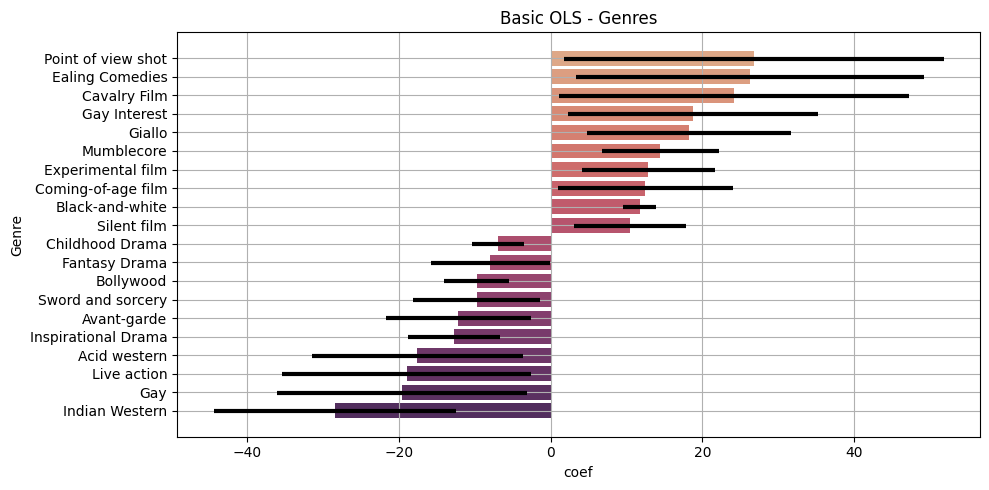

In [9]:
def map_genres_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_genres[df_genres['genres'] == x]))
    return df

genres_ols_results, genres_ols_significant = study_OLS(
    one_hot_movies_genres,
    one_hot_movies_genres_columns,
    'rating_difference',
    colname='Genre',
    regularization=None,
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='Basic OLS - Genres',
    map_columns_name=map_genres_columns,
    limit_tops=20
)

The first naive OLS tries to fit all the features to the `rating_difference` column. The results might seem good at first, with quite a lot of variables being significant (with respect to the commont pvalue threshold of 0.05) and an adjusted R<sup>2</sup> of 0.157. However, the condition number is very, very high, triggering a warning about multicollinearity. This is not surprising, as the number of features is very high and the number of observations is quite low. The model is thus not very reliable. We'll try to improve it by removing some features through a variance inflation factor analysis.

### VIF (Variance Inflation Factor) Filtering

In [10]:
genres_vif_significant = filter_VIF(one_hot_movies_genres, genres_pearsonr_significant, threshold=5)

print(f"Number of genres after filtering: {len(genres_vif_significant)}/{len(genres_pearsonr_significant)}")

 90%|████████▉ | 87/97 [00:09<00:01,  9.31it/s]c:\Users\anton\Documents\MA3\ada-2023-project-radatouille\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
100%|██████████| 97/97 [00:10<00:00,  9.30it/s]

Number of genres after filtering: 93/97


The VIF threshold is selected as 5, which is a common value. Luckily, we only lost 4 genres through this process and can now run a new OLS.

### OLS

Dep. Variable:,rating_difference,R-squared:,0.146
Model:,OLS,Adj. R-squared:,0.135
Method:,Least Squares,F-statistic:,14.07
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,8.10e-195
Time:,23:03:13,Log-Likelihood:,-30158.
No. Observations:,7770,AIC:,6.050e+04
Df Residuals:,7676,BIC:,6.116e+04
Df Model:,93,,
Covariance Type:,nonrobust,,


Omnibus:,71.607,Durbin-Watson:,1.931
Prob(Omnibus):,0.000,Jarque-Bera (JB):,73.389
Skew:,-0.234,Prob(JB):,1.16e-16
Kurtosis:,3.084,Cond. No.,118.




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.145628,0.135276,9.406099,137.666235
baseline,0.0,0.0,10.266286,161.131427
improvement,inf,inf,-8.38%,-14.56%


Significant results: 22/93

Top 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Genre
2,onehot-genre_Black-and-white,12.5515,0.000,10.436,14.667,Black-and-white,145,Black-and-white
6,onehot-genre_New Hollywood,8.3654,0.000,5.280,11.451,New Hollywood,59,New Hollywood
5,onehot-genre_Film noir,4.6907,0.003,1.595,7.786,Film noir,62,Film noir
0,onehot-genre_World cinema,4.3842,0.000,3.572,5.196,World cinema,1240,World cinema
11,onehot-genre_Comedy of manners,3.7406,0.002,1.417,6.065,Comedy of manners,107,Comedy of manners
3,onehot-genre_Art film,3.3571,0.007,0.923,5.791,Art film,103,Art film
4,onehot-genre_Documentary,3.1940,0.000,1.825,4.563,Documentary,659,Documentary
9,onehot-genre_Animation,3.1268,0.000,1.552,4.701,Animation,303,Animation
1,onehot-genre_Drama,2.8056,0.000,2.094,3.517,Drama,4331,Drama
7,onehot-genre_History,1.7252,0.046,0.031,3.420,History,228,History



Bottom 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Genre
10,onehot-genre_Romantic drama,-1.0183,0.043,-2.002,-0.034,Romantic drama,747,Romantic drama
16,onehot-genre_Crime Thriller,-1.2836,0.036,-2.484,-0.084,Crime Thriller,576,Crime Thriller
14,onehot-genre_Sports,-1.7146,0.019,-3.153,-0.277,Sports,284,Sports
17,onehot-genre_Romantic comedy,-2.0941,0.000,-3.162,-1.026,Romantic comedy,706,Romantic comedy
21,onehot-genre_Action,-2.7036,0.000,-3.748,-1.659,Action,1395,Action
18,onehot-genre_Slasher,-2.8287,0.011,-5.014,-0.643,Slasher,161,Slasher
19,onehot-genre_Teen,-3.2990,0.000,-4.757,-1.841,Teen,314,Teen
20,onehot-genre_Slapstick,-4.7729,0.000,-6.778,-2.768,Slapstick,149,Slapstick
13,onehot-genre_Bollywood,-7.4867,0.001,-11.767,-3.206,Bollywood,31,Bollywood
15,onehot-genre_Inspirational Drama,-8.1484,0.008,-14.201,-2.096,Inspirational Drama,15,Inspirational Drama


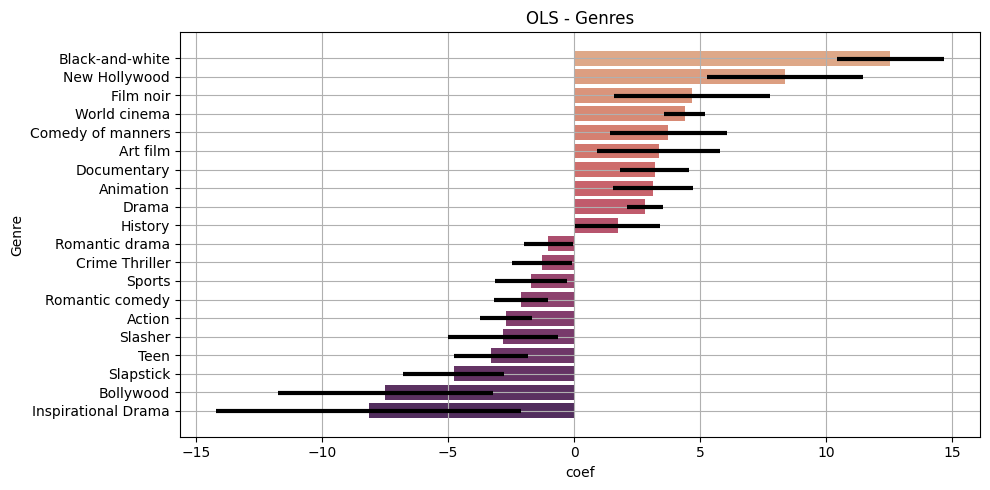

In [11]:
def map_genres_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_genres[df_genres['genres'] == x]))
    return df

genres_ols_results, genres_ols_significant = study_OLS(
    one_hot_movies_genres,
    genres_vif_significant,
    'rating_difference',
    colname='Genre',
    regularization='l1',
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='OLS - Genres',
    map_columns_name=map_genres_columns
)

The results after VIF filtering looks way more reliable. The adjusted R<sup>2</sup> is now 0.135, which is lower than before, but the condition number is now 118, which is way better. Thos indicates the fit of our model is overall better, and luckily, the plot is also showing more interesting genres. The outliers are seemingly gone, and confidence interval are overall smaller. On the critics side, the `Black and white` and `New Hollywood` moives are performing the best, while on the public side, `Inspirational Drama` and `Bollywood` seem to stand out. However, those two genres have very wide confidence intervals, so we'd better be a bit careful before jumping to concludions. The Action movies for instance, are maybe more reliable as an indicator of public success, as the confidence interval is quite small, but it's overall `rating_difference` is quite low.

### Conclusion

Despite having filtering out some features thus lowering the overall adjusted R<sup>2</sup>, the model seems more reliable. The OLS, while explaining less of the variance, is probably a better fit to the reality now. 

In [18]:
#export_json(genres_ols_results, 'website/public/data/genres-3.json')

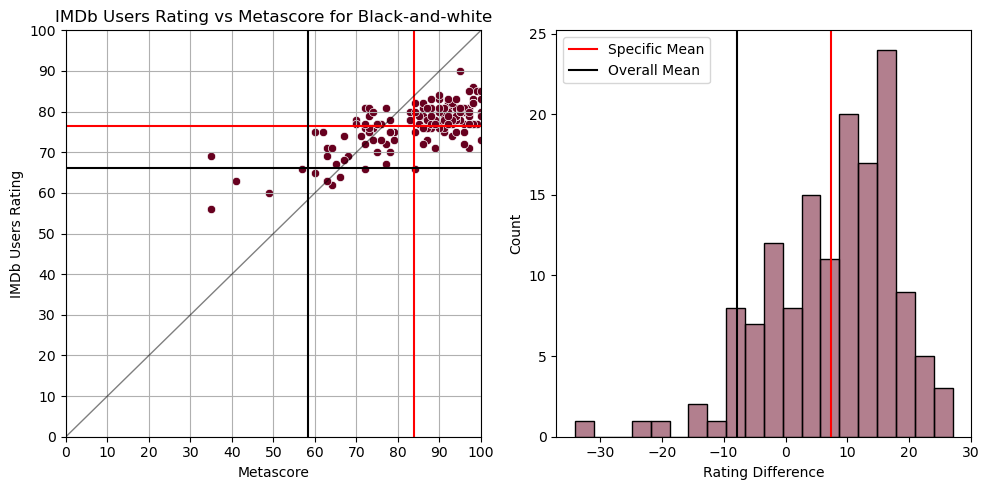

In [19]:
plot_specific_scatter(df_genres, 'genres', 'Black-and-white')

In [12]:
def output_playground_genres(path):
    merged_df = df_genres[df_genres['genres'].isin(genres_ols_results['Genre'])] \
        .merge(genres_ols_results, left_on='genres', right_on='Genre') \
        .groupby('genres') \
        .apply(lambda x: {'ids': x['imdb_id'].tolist(), 'ols_coefficient': x['coef'].iloc[0]}) \
        .to_json(path)

In [13]:
output_playground_genres('website/public/data/playground-genres.json')


## Actors

### Preprocessing

In [21]:
data_characters = pd.read_csv('data/preprocessed/character.metadata.preprocessed.tsv', sep='\t')

# Filter out movies that are not in the movies dataset
data_characters = data_characters[data_characters['wikipedia_id'].isin(data['wikipedia_id'])]

print(f'Actors: {len(data_characters["freebase_actor_id"].unique())}')

Actors: 22416


In [22]:
movies_threshold = 6
df_actors = process_actors(data_characters, movies_threshold=movies_threshold)

print(f"Actors with >={movies_threshold} movies: {len(df_actors['freebase_actor_id'].unique())}/{len(data_characters['freebase_actor_id'].unique())}")
print(f"Movies with actors with >={movies_threshold} movies: {len(df_actors['wikipedia_id'].unique())}/{len(data)}")

Actors with >=6 movies: 3151/22416
Movies with actors with >=6 movies: 6156/7770


### Hotencoding

In [23]:
# Hot encode the actor freebase id column 
one_hot_actors, one_hot_actors_columns = hotencode(df_actors, 'freebase_actor_id', id_column='wikipedia_id', prefix='onehot-actor')

# Add the rating_difference column to the one hot encoded dataframe
one_hot_actors = one_hot_actors.merge(data[['wikipedia_id', 'rating_difference']], on='wikipedia_id')

print(one_hot_actors.shape)

(6156, 3153)


### Pearson Correlation

Significant results: 426/3151

Top 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,actor_name
onehot-actor_/m/02hfsd,0.062650,8.682663e-07,0.037728,0.087494,onehot-actor_/m/02hfsd,/m/02hfsd,10,Ward Bond
onehot-actor_/m/04sry,0.061693,1.272015e-06,0.036768,0.086541,onehot-actor_/m/04sry,/m/04sry,16,Martin Scorsese
onehot-actor_/m/0cbkc,0.061683,1.277098e-06,0.036758,0.086531,onehot-actor_/m/0cbkc,/m/0cbkc,20,Catherine Deneuve
onehot-actor_/m/021t8p,0.056423,9.441287e-06,0.031486,0.081290,onehot-actor_/m/021t8p,/m/021t8p,11,Michel Piccoli
onehot-actor_/m/09qh1,0.055850,1.162556e-05,0.030911,0.080718,onehot-actor_/m/09qh1,/m/09qh1,9,Cary Grant
onehot-actor_/m/016yvw,0.055024,1.563473e-05,0.030084,0.079895,onehot-actor_/m/016yvw,/m/016yvw,14,Daniel Day-Lewis
onehot-actor_/m/0668qk,0.054638,1.792995e-05,0.029697,0.079511,onehot-actor_/m/0668qk,/m/0668qk,10,Olivier Gourmet
onehot-actor_/m/0p8r1,0.053008,3.167281e-05,0.028064,0.077886,onehot-actor_/m/0p8r1,/m/0p8r1,19,John Ratzenberger
onehot-actor_/m/014zcr,0.052987,3.190623e-05,0.028042,0.077865,onehot-actor_/m/014zcr,/m/014zcr,31,George Clooney
onehot-actor_/m/043gj,0.052856,3.337227e-05,0.027912,0.077735,onehot-actor_/m/043gj,/m/043gj,14,John Wayne



Bottom 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,actor_name
onehot-actor_/m/0b10t7,-0.047611,1.862758e-04,-0.072506,-0.022657,onehot-actor_/m/0b10t7,/m/0b10t7,6,Doug Hutchison
onehot-actor_/m/04bk4c,-0.048098,1.598941e-04,-0.072991,-0.023144,onehot-actor_/m/04bk4c,/m/04bk4c,13,Rachel Dratch
onehot-actor_/m/0670jl,-0.048175,1.560686e-04,-0.073068,-0.023221,onehot-actor_/m/0670jl,/m/0670jl,22,Ethan Suplee
onehot-actor_/m/01dkpb,-0.049798,9.276246e-05,-0.074686,-0.024848,onehot-actor_/m/01dkpb,/m/01dkpb,18,Charles Bronson
onehot-actor_/m/03hv_6,-0.053159,3.007039e-05,-0.078036,-0.028215,onehot-actor_/m/03hv_6,/m/03hv_6,13,Lochlyn Munro
onehot-actor_/m/038rzr,-0.053230,2.933590e-05,-0.078108,-0.028287,onehot-actor_/m/038rzr,/m/038rzr,26,Gerard Butler
onehot-actor_/m/01fyzy,-0.054207,2.087292e-05,-0.079081,-0.029265,onehot-actor_/m/01fyzy,/m/01fyzy,21,Rob Schneider
onehot-actor_/m/06rq2l,-0.056486,9.225182e-06,-0.081353,-0.031550,onehot-actor_/m/06rq2l,/m/06rq2l,15,Allen Covert
onehot-actor_/m/01p4vl,-0.060183,2.297445e-06,-0.085037,-0.035255,onehot-actor_/m/01p4vl,/m/01p4vl,21,Ashton Kutcher
onehot-actor_/m/0pz91,-0.063940,5.143203e-07,-0.088780,-0.039021,onehot-actor_/m/0pz91,/m/0pz91,35,Adam Sandler


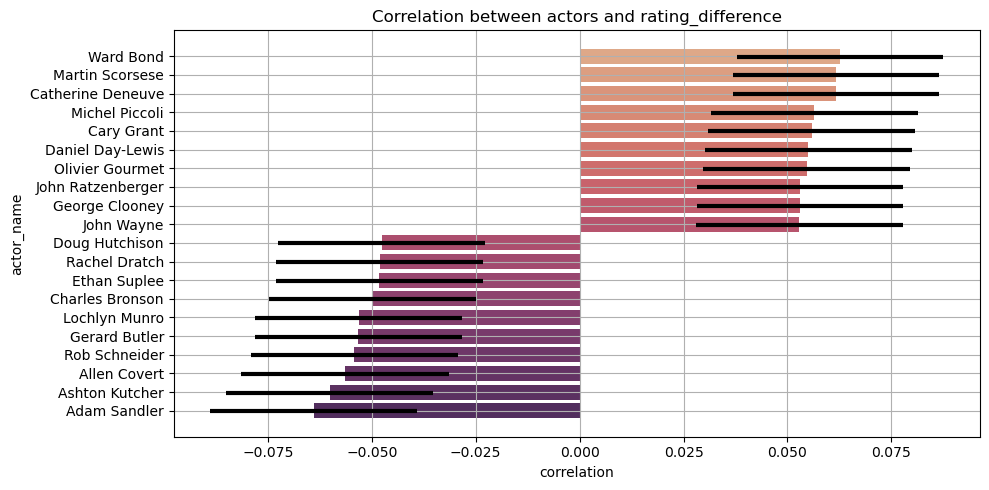

In [24]:
def map_actors_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_actors[df_actors['freebase_actor_id'] == x]))
    df['actor_name'] = df['col_id'].apply(lambda x: df_actors[df_actors['freebase_actor_id'] == x]['actor_name'].iloc[0])

    return df

actors_pearsonr_results, actors_pearsonr_significant = study_pearson(
    one_hot_actors,
    one_hot_actors_columns,
    'rating_difference',
    colname='actor_name',
    threshold=0.05,
    print_results=True,
    plot_barplot=True,
    map_columns_name=map_actors_columns,
    title="Correlation between actors and rating_difference"
)

The Pearson correlation seems to give already almost satisfactory results, since the top 10 actors are all actors that are known to be very good, most of them renowned for their roles in old movies. While the confidence interval are not small, they seem pretty consistent accross all the actors. This high CI can be explained by the relatively small number of films each actors has been starred in, compared to the overall number of film. This first analysis thus reduces the number of actors to a more manageable number, and gives us a good idea of which actors are the most popular.

In [25]:
#export_json(actors_pearsonr_results, 'website/public/data/actors-1.json')

### OLS

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.190
Model:,OLS,Adj. R-squared:,0.130
Method:,Least Squares,F-statistic:,3.152
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,6.41e-82
Time:,16:34:48,Log-Likelihood:,-23678.
No. Observations:,6156,AIC:,4.821e+04
Df Residuals:,5729,BIC:,5.108e+04
Df Model:,426,,
Covariance Type:,nonrobust,,


Omnibus:,40.761,Durbin-Watson:,1.911
Prob(Omnibus):,0.000,Jarque-Bera (JB):,36.081
Skew:,-0.139,Prob(JB):,1.46e-08
Kurtosis:,2.748,Cond. No.,60.1




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.189875,0.129636,9.178058,128.332337
baseline,0.0,0.0,10.210021,158.41059
improvement,inf,inf,-10.11%,-18.99%


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Significant results: 20/426


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,actor_name
4,onehot-actor_/m/09qh1,10.8644,0.008,2.780,18.948,/m/09qh1,9,Cary Grant
0,onehot-actor_/m/02hfsd,9.8099,0.018,1.682,17.938,/m/02hfsd,10,Ward Bond
1,onehot-actor_/m/04sry,9.3952,0.003,3.305,15.485,/m/04sry,16,Martin Scorsese
6,onehot-actor_/m/0668qk,9.3611,0.024,1.206,17.517,/m/0668qk,10,Olivier Gourmet
2,onehot-actor_/m/0cbkc,8.9386,0.002,3.323,14.554,/m/0cbkc,20,Catherine Deneuve
9,onehot-actor_/m/04__f,8.9355,0.017,1.571,16.300,/m/04__f,11,Marlon Brando
3,onehot-actor_/m/021t8p,8.5990,0.025,1.095,16.103,/m/021t8p,11,Michel Piccoli
8,onehot-actor_/m/014zcr,7.0277,0.001,2.702,11.354,/m/014zcr,31,George Clooney
7,onehot-actor_/m/0p8r1,7.0203,0.013,1.457,12.583,/m/0p8r1,19,John Ratzenberger
5,onehot-actor_/m/016yvw,6.9141,0.032,0.577,13.252,/m/016yvw,14,Daniel Day-Lewis


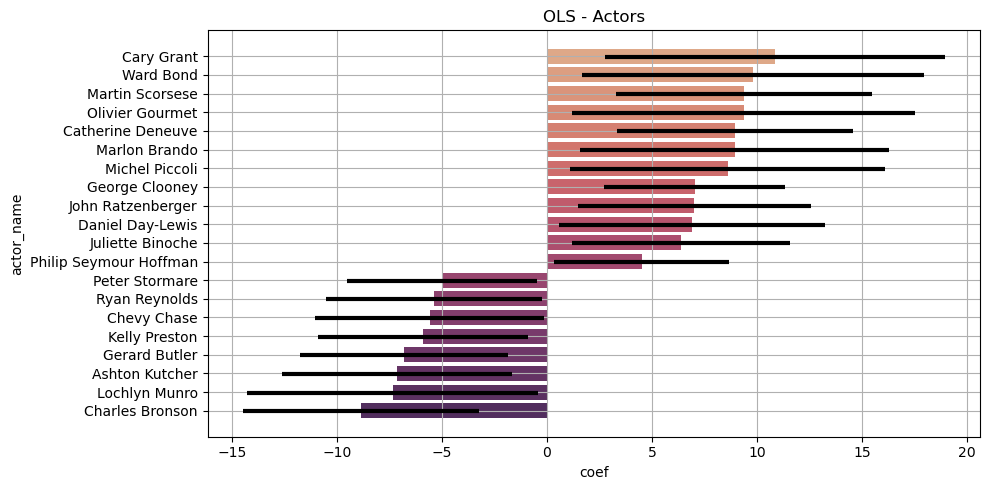

In [26]:
# Fit a OLS model
def map_actors_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_actors[df_actors['freebase_actor_id'] == x]))
    df['actor_name'] = df['col_id'].map(lambda x: df_actors[df_actors['freebase_actor_id'] == x]['actor_name'].iloc[0])

    return df

actors_ols_results, actors_ols_significant = study_OLS(
    one_hot_actors,
    actors_pearsonr_significant,
    'rating_difference',
    colname='actor_name',
    regularization='l1',
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='OLS - Actors',
    map_columns_name=map_actors_columns
)

The condition number is in a managable range, and no multicollinearity seem to be detected. The adjusted R<sup>2</sup> is 0.130. The confidence interval are quite large, but this is to be expected given the small number of movies each actor has been in. 

In [27]:
#export_json(actors_ols_results, 'website/public/data/actors-2.json')

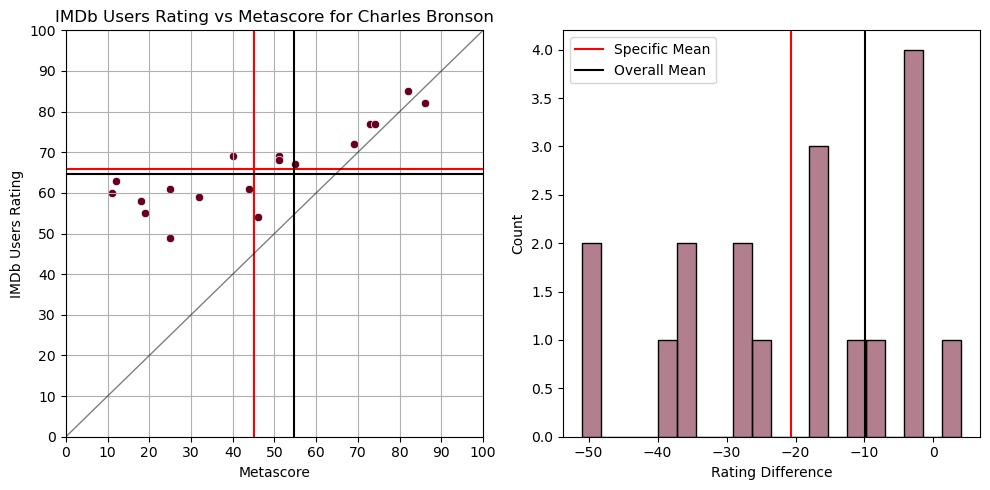

In [28]:
plot_specific_scatter(df_actors.merge(data[['wikipedia_id', 'imdb_rating_scaled', 'metascore', 'rating_difference']], on='wikipedia_id'), 'actor_name', 'Charles Bronson')

In [29]:
actors_ols_results

,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,actor_name
4,onehot-actor_/m/09qh1,10.8644,0.008,2.780,18.948,/m/09qh1,9,Cary Grant
0,onehot-actor_/m/02hfsd,9.8099,0.018,1.682,17.938,/m/02hfsd,10,Ward Bond
1,onehot-actor_/m/04sry,9.3952,0.003,3.305,15.485,/m/04sry,16,Martin Scorsese
6,onehot-actor_/m/0668qk,9.3611,0.024,1.206,17.517,/m/0668qk,10,Olivier Gourmet
2,onehot-actor_/m/0cbkc,8.9386,0.002,3.323,14.554,/m/0cbkc,20,Catherine Deneuve
9,onehot-actor_/m/04__f,8.9355,0.017,1.571,16.300,/m/04__f,11,Marlon Brando
3,onehot-actor_/m/021t8p,8.5990,0.025,1.095,16.103,/m/021t8p,11,Michel Piccoli
8,onehot-actor_/m/014zcr,7.0277,0.001,2.702,11.354,/m/014zcr,31,George Clooney
7,onehot-actor_/m/0p8r1,7.0203,0.013,1.457,12.583,/m/0p8r1,19,John Ratzenberger
5,onehot-actor_/m/016yvw,6.9141,0.032,0.577,13.252,/m/016yvw,14,Daniel Day-Lewis


In [30]:
# save all imdb_ids per actor
df_actors \
    .merge(data[['imdb_id', 'freebase_id']], on='freebase_id', how='left') \
    .loc[df_actors.merge(data[['imdb_id', 'freebase_id']], on='freebase_id', how='left')['actor_name'].isin(actors_ols_results['actor_name'])]  \
    .groupby('actor_name') \
    .apply(lambda x: x['imdb_id'].tolist()) \
    .to_json('website/public/data/playground-actors.json')


## Runtime

In [31]:
df_runtime = data.copy()
df_runtime.dropna(subset=['runtime'], inplace=True)
print(f"Movies with runtime value: {len(df_runtime)}/{len(data)}")

Movies with runtime value: 7493/7770


### Visual exploration

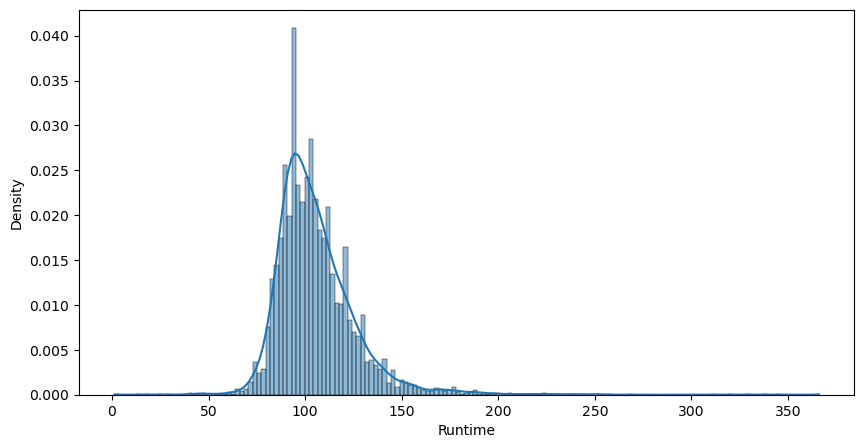

In [32]:
# Plot distribution of runtime
plt.figure(figsize=(10,5))
sns.histplot(df_runtime['runtime'], kde=True, stat='density', alpha=0.5)
plt.xlabel('Runtime')
plt.ylabel('Density')
plt.show()

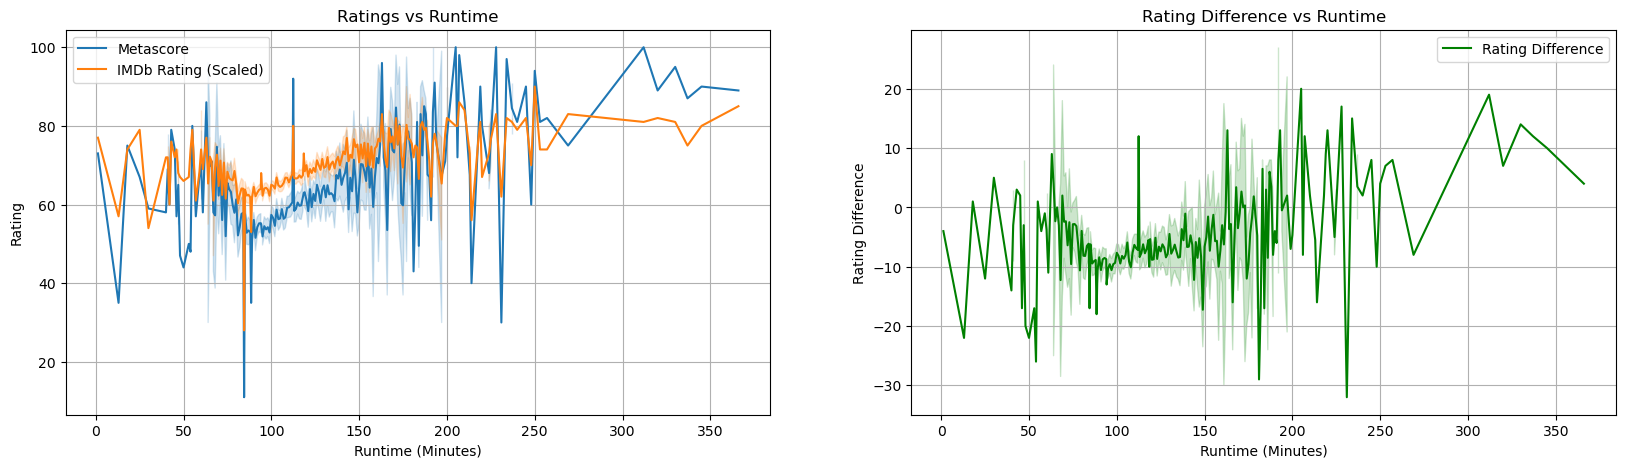

In [33]:
# Plot the distribution of rating difference per runtime
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="runtime", y="metascore", data=df_runtime, label='Metascore', ax=ax[0])
sns.lineplot(x="runtime", y="imdb_rating_scaled", data=df_runtime, label='IMDb Rating (Scaled)', ax=ax[0])

sns.lineplot(x="runtime", y="rating_difference", data=df_runtime, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Runtime")
ax[0].set_xlabel("Runtime (Minutes)")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Runtime")
ax[1].set_xlabel("Runtime (Minutes)")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

The plot shows a noisy relationship between rating difference and runtime, with no clear pattern. The data points are widely spread out, indicating a lot of variability in the rating differences for movies of similar lengths.

### Pearson correlation

In [34]:
runtime_pearsonr_results = perform_pearsonr(df_runtime, ['runtime'], 'rating_difference', print_results=True)

,correlation,p_value,lower_ci,upper_ci
runtime,0.077735,1.605720e-11,0.05519,0.100202


### OLS

In [35]:
# Fit OLS
runtime_ols_results, runtime_ols_significant = study_OLS(df_runtime, ['runtime'], 'rating_difference', plot_barplot=False)

Dep. Variable:,rating_difference,R-squared:,0.006
Model:,OLS,Adj. R-squared:,0.006
Method:,Least Squares,F-statistic:,45.54
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,1.61e-11
Time:,16:34:51,Log-Likelihood:,-29623.
No. Observations:,7493,AIC:,5.925e+04
Df Residuals:,7491,BIC:,5.926e+04
Df Model:,1,,
Covariance Type:,nonrobust,,


Omnibus:,74.015,Durbin-Watson:,2.012
Prob(Omnibus):,0.000,Jarque-Bera (JB):,71.405
Skew:,-0.212,Prob(JB):,3.12e-16
Kurtosis:,2.780,Cond. No.,547.




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.006043,0.00591,10.208985,158.997098
baseline,0.0,0.0,10.231745,159.963723
improvement,inf,inf,-0.22%,-0.6%


Significant results: 1/1


,feature,coef,p_value,lower_ci,upper_ci,col_id,col_name
0,runtime,0.0463,0.0,0.033,0.06,,


- The R-squared value is 0.006, which means that only 0.6% of the variance in the rating difference is explained by the runtime. This indicates a very weak linear relationship between runtime and rating difference.
  
- The constant (intercept) coefficient is -12.7768 with a p-value close to 0, suggesting that the intercept is significantly different from 0. However, given that runtime cannot be 0, the practical interpretation of the intercept is limited.
  
- The runtime coefficient is 0.0463, indicating that for every additional minute of runtime, the rating difference increases by 0.0463 on average. While this is statistically significant (p-value < 0.001), the effect size is very small.

## Release date

### Preprocessing

In [36]:
df_release_date = data.copy()
df_release_date['release_date_datetime'] = pd.to_datetime(df_release_date['release_date_datetime'])
df_release_date['year'] = df_release_date['release_date_datetime'].dt.year
df_release_date['month'] = df_release_date['release_date_datetime'].dt.month

df_release_date = df_release_date.dropna(subset=['year', 'month'])
df_release_date['year'] = df_release_date['year'].astype(int)
print(f'Movies with a release date and month: {len(df_release_date)}/{len(data)}')

Movies with a release date and month: 7702/7770


### Visual exploration

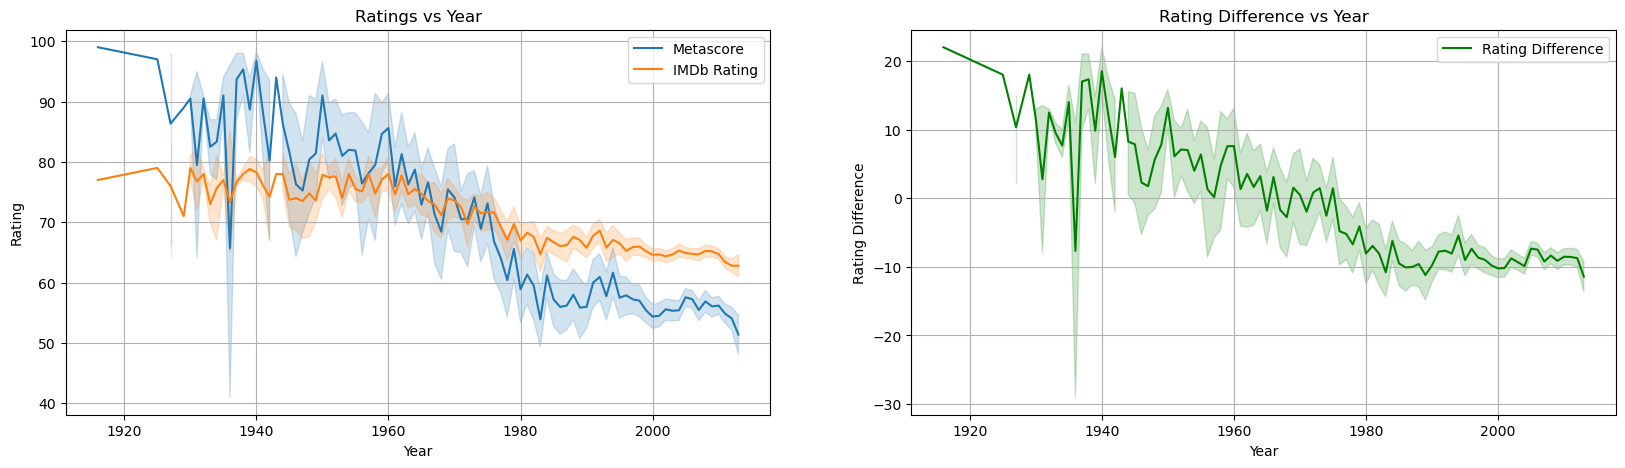

In [37]:
# Plot the distribution of rating difference per year
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="year", y="metascore", data=df_release_date, label='Metascore', ax=ax[0])
sns.lineplot(x="year", y="imdb_rating_scaled", data=df_release_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="year", y="rating_difference", data=df_release_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Year")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The first set of plots shows that both the Metascore and IMDb rating have a general downward trend over the years. This could suggest that either movies are getting worse, or perhaps more likely, that scoring criteria have become stricter over time.

- The plot for rating differences over the years indicates that the gap between Metascore and IMDb ratings has generally been widening. Early in the data, Metascore ratings are higher than IMDb, and over time, this trend reverses.

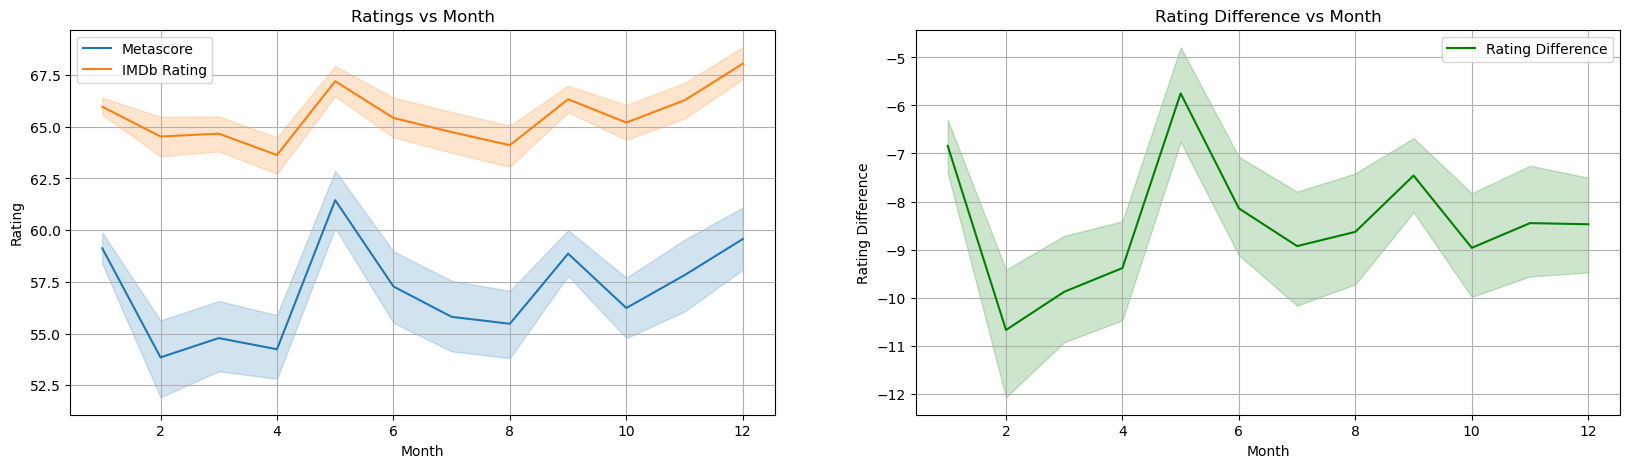

In [38]:
# Plot the distribution of rating difference per month
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="month", y="metascore", data=df_release_date, label='Metascore', ax=ax[0])
sns.lineplot(x="month", y="imdb_rating_scaled", data=df_release_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="month", y="rating_difference", data=df_release_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Month")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The monthly plots indicate some seasonality in ratings, with certain months having higher or lower average ratings. This could be due to the type of movies typically released in those months (e.g., Oscar-bait films in December).

- The monthly rating difference plot shows that the discrepancy between the two rating sources also varies by month, with some months showing a larger gap than others.

### Pearson correlation

In [39]:
release_date_pearsonr_results = perform_pearsonr(df_release_date, ['year'], 'rating_difference', print_results=True)

release_date_pearsonr_results['colname'] = release_date_pearsonr_results.index

,correlation,p_value,lower_ci,upper_ci
year,-0.201596,1.906067e-71,-0.222926,-0.180074


### OLS

In [40]:
# Fit a linear regression model
release_date_ols_results, release_date_ols_significant = study_OLS(
    df_release_date,
    ['year'],
    'rating_difference',
    colname='Release Date',
    regularization=None,
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    plot_barplot=False,
    title='OLS - Release Date'
)

Dep. Variable:,rating_difference,R-squared:,0.041
Model:,OLS,Adj. R-squared:,0.041
Method:,Least Squares,F-statistic:,326.2
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,1.91e-71
Time:,16:34:53,Log-Likelihood:,-30333.
No. Observations:,7702,AIC:,6.067e+04
Df Residuals:,7700,BIC:,6.068e+04
Df Model:,1,,
Covariance Type:,nonrobust,,


Omnibus:,97.676,Durbin-Watson:,2.018
Prob(Omnibus):,0.000,Jarque-Bera (JB):,101.046
Skew:,-0.278,Prob(JB):,1.14e-22
Kurtosis:,2.923,Cond. No.,3.00e+05




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.040641,0.040517,10.057575,154.294307
baseline,0.0,0.0,10.25373,160.830642
improvement,inf,inf,-1.91%,-4.06%


Significant results: 1/1


,feature,coef,p_value,lower_ci,upper_ci,col_id,Release Date
0,year,-0.1919,0.0,-0.213,-0.171,,


- The model suggests that both year and month are significant predictors of the rating difference.

- The coefficient for year is -0.1925, indicating that with each passing year, the rating difference decreases by 0.1925 points. Given the R-squared value of 0.041, we know that year and month together explain about 4.1% of the variance in rating difference, which is not a lot, but it is significant.

- The coefficient for month is -0.0953, suggesting a smaller but still significant monthly effect on rating differences.

In [41]:
df_release_date \
    .groupby('year') \
    .apply(lambda x: x['imdb_id'].tolist()) \
    .to_json('website/public/data/playground-releaseyear.json')

## Countries

In [42]:
data_countries = process_countries(data)

# Filter out countries with less than 10 movies
countries_threshold = 10
df_countries = data_countries.groupby('countries').filter(lambda x: len(x) >= countries_threshold)

print(f"Movies with countries: {len(df_countries['freebase_id'].unique())}/{len(data)}")
print(f"Countries with >={countries_threshold} movies: {len(df_countries['countries'].unique())}/{len(data_countries['countries'].unique())}")

Movies with countries: 7660/7770
Countries with >=10 movies: 44/116


### Basic visual exploration


Top 15:


,countries,rating_difference
18,Iran,3.864865
28,Poland,0.250000
38,Taiwan,-0.166667
9,England,-0.444444
37,Switzerland,-0.475410
27,Norway,-0.931034
29,Portugal,-1.272727
10,Finland,-1.952381
40,Turkey,-2.300000
31,Russia,-2.511628



Bottom 15:


,countries,rating_difference
23,Luxembourg,-6.600000
14,Hong Kong,-6.653061
35,Spain,-6.721925
20,Israel,-6.779661
15,Hungary,-7.125000
16,Iceland,-7.153846
13,Greece,-7.272727
33,South Africa,-7.909091
1,Australia,-8.220000
25,Netherlands,-8.657534


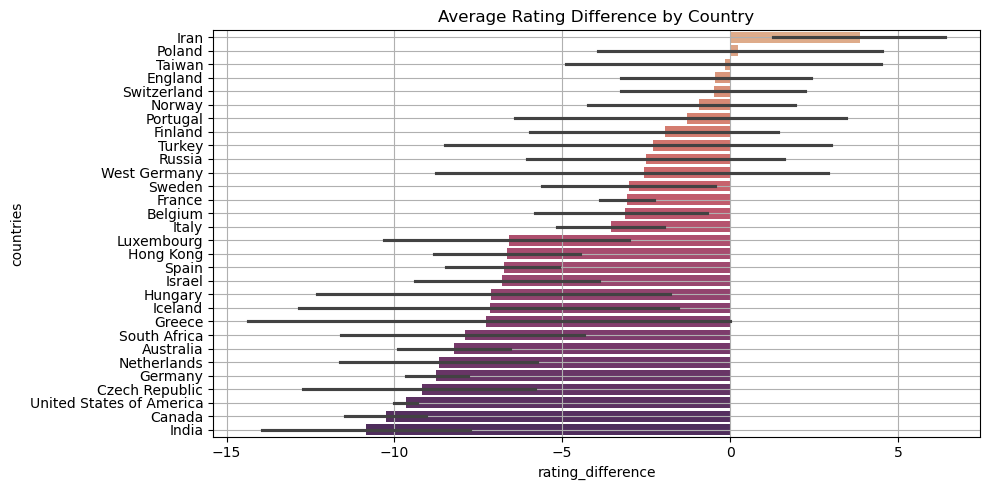

In [43]:
# Plot the barplot of rating difference per country (sorted by mean rating difference)

# Group by country and calculate average rating_difference for each country
country_scores = df_countries.groupby('countries')['rating_difference'].mean().reset_index()

if len(country_scores) > 30:
    country_scores_sorted = country_scores.sort_values(by='rating_difference', ascending=False)

    print('\nTop 15:')
    display(country_scores_sorted.head(15))

    print('\nBottom 15:')
    display(country_scores_sorted.tail(15))

    plot_results(df_countries.loc[df_countries['countries'].isin(pd.concat([country_scores_sorted.head(15)['countries'], country_scores_sorted.tail(15)['countries']]))], 'countries', 'rating_difference', 'Average Rating Difference by Country')
else:
    display(country_scores)
    plot_results(df_countries, 'countries', 'rating_difference', 'Average Rating Difference by Country')


In [44]:
# Export the data to a json file
#export_json(df_countries.groupby('countries')['rating_difference'].agg(['mean', 'sem', 'count']).reset_index(), 'website/public/data/countries-1.json')

### Hotencoding

In [45]:
# Hot encode countries per movie
one_hot_countries, one_hot_countries_columns = hotencode(df_countries, 'countries', id_column='freebase_id', prefix='onehot-country')

# Add the rating_difference column
one_hot_countries = one_hot_countries.merge(df_countries[['freebase_id', 'rating_difference']].drop_duplicates(), on='freebase_id')

print(one_hot_countries.shape)

(7660, 46)


### Pearson Correlation

Significant results: 19/44


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Country
onehot-country_France,0.141118,2.278254e-35,0.119100,0.162998,onehot-country_France,France,890,France
onehot-country_Italy,0.067219,3.891008e-09,0.044891,0.089479,onehot-country_Italy,Italy,270,Italy
onehot-country_Iran,0.065230,1.102548e-08,0.042898,0.087497,onehot-country_Iran,Iran,37,Iran
onehot-country_Switzerland,0.053188,3.198108e-06,0.030830,0.075493,onehot-country_Switzerland,Switzerland,61,Switzerland
onehot-country_United Kingdom,0.050248,1.083434e-05,0.027884,0.072561,onehot-country_United Kingdom,United Kingdom,1136,United Kingdom
onehot-country_Belgium,0.042683,1.863819e-04,0.020308,0.065016,onehot-country_Belgium,Belgium,93,Belgium
onehot-country_Japan,0.041391,2.905692e-04,0.019014,0.063727,onehot-country_Japan,Japan,248,Japan
onehot-country_England,0.040961,3.358867e-04,0.018584,0.063298,onehot-country_England,England,36,England
onehot-country_Poland,0.039426,5.576524e-04,0.017047,0.061766,onehot-country_Poland,Poland,28,Poland
onehot-country_Sweden,0.036764,1.290021e-03,0.014381,0.059110,onehot-country_Sweden,Sweden,66,Sweden


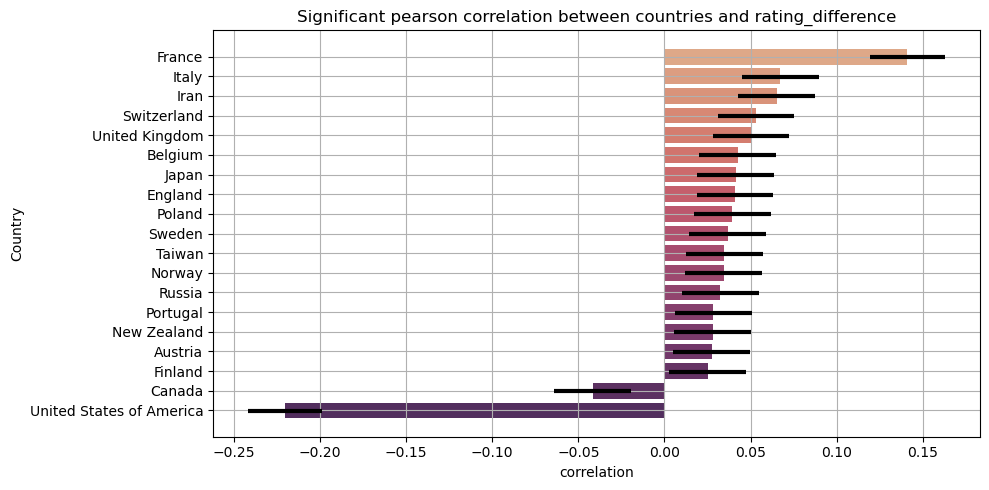

In [46]:
def map_countries_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_countries[df_countries['countries'] == x]))
    return df

countries_pearsonr_results, countries_pearsonr_significant = study_pearson(
    one_hot_countries,
    one_hot_countries_columns,
    'rating_difference',
    colname='Country',
    threshold=0.05,
    print_results=True,
    title="Significant pearson correlation between countries and rating_difference",
    map_columns_name=map_countries_columns
)

In [47]:
# Export the data to a json file
#export_json(countries_pearsonr_results, 'website/public/data/countries-2.json')

### OLS

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.065
Model:,OLS,Adj. R-squared:,0.059
Method:,Least Squares,F-statistic:,11.99
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,6.56e-81
Time:,16:34:54,Log-Likelihood:,-30061.
No. Observations:,7660,AIC:,6.021e+04
Df Residuals:,7615,BIC:,6.053e+04
Df Model:,44,,
Covariance Type:,nonrobust,,


Omnibus:,45.399,Durbin-Watson:,1.906
Prob(Omnibus):,0.000,Jarque-Bera (JB):,45.205
Skew:,-0.175,Prob(JB):,1.53e-10
Kurtosis:,2.864,Cond. No.,37.0




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.064795,0.059392,9.853622,150.066263
baseline,0.0,0.0,10.249182,160.463556
improvement,inf,inf,-3.86%,-6.48%


Significant results: 6/44


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Country
4,onehot-country_Iran,5.4761,0.008,1.462,9.490,Iran,37,Iran
1,onehot-country_France,2.5242,0.000,1.539,3.510,France,890,France
2,onehot-country_Germany,-2.1297,0.000,-3.167,-1.092,Germany,659,Germany
0,onehot-country_Canada,-2.8480,0.000,-4.103,-1.593,Canada,395,Canada
3,onehot-country_India,-4.0270,0.007,-6.968,-1.086,India,69,India
5,onehot-country_United States of America,-5.8253,0.000,-6.628,-5.022,United States of America,5670,United States of America


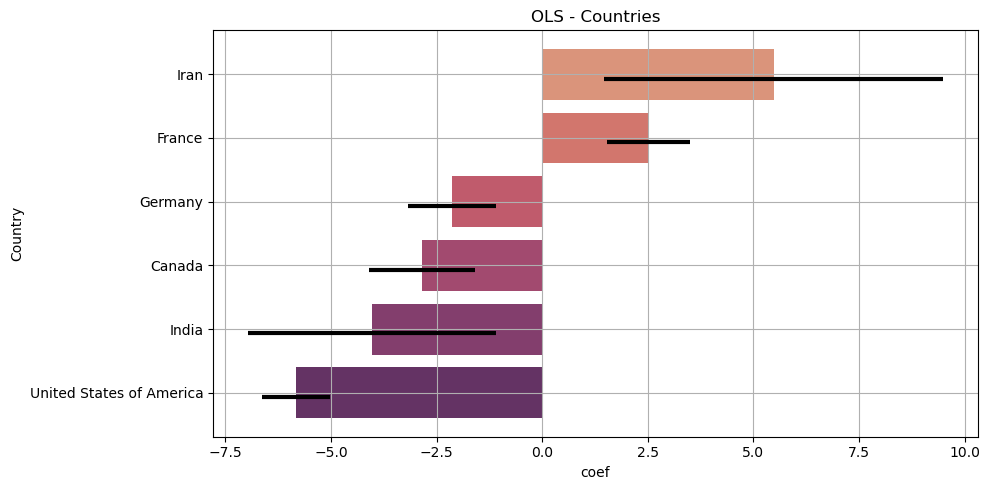

In [48]:
countries_ols_results, countries_ols_significant = study_OLS(
    one_hot_countries,
    one_hot_countries_columns,
    'rating_difference',
    colname='Country',
    regularization='l1',
    alpha=0.01,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    title='OLS - Countries',
    map_columns_name=map_countries_columns
)

- The Adjusted R-squared value is 0.059, meaning that roughly 5.9% of the variance in the rating difference can be explained by the model. This is a significant improvement from previous models you mentioned, but still suggests that there are other factors not included in the model that influence the rating difference.
- The Condition Number is 28.7 which is below the recommended threshold of 30, indicating that multicollinearity is not a problem and that the model is stable.
- The Prob(F-statistic) is very close to 0, indicating that the model is statistically significant.

In [49]:
# Export the data to a json file
#export_json(countries_ols_results, 'website/public/data/countries-3.json')

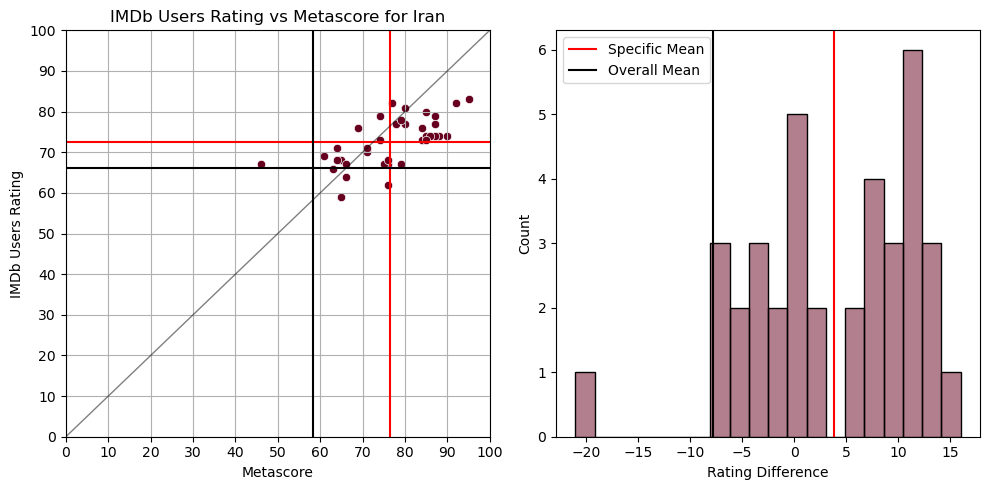

In [50]:
plot_specific_scatter(df_countries, 'countries', 'Iran')

In [51]:
# save all imdb_ids per country
df_countries \
    .loc[df_countries['countries'].isin(countries_ols_results['Country'])]  \
    .groupby('countries') \
    .apply(lambda x: x['imdb_id'].tolist()) \
    .to_json('website/public/data/playground-countries.json')


## Tropes

### Preprocessing

In [14]:
data_tropes = pd.read_csv('data/processed/tropes.csv')

In [15]:
df_tropes = data_tropes.copy()
print(f"Movies with tropes: {len(df_tropes['imdb_id'].unique())}/{len(data['imdb_id'].unique())}")

Movies with tropes: 2741/7770


In [16]:
# Keep tropes with at least n movies
n = 20
df_tropes = df_tropes.groupby('trope_id').filter(lambda x: len(x) >= n)
print(f"Unique tropes after filtering: {len(df_tropes['trope_id'].unique())}/{len(data_tropes['trope_id'].unique())}")
print(f"Movies with tropes after filtering: {len(df_tropes['imdb_id'].unique())}/{len(data['imdb_id'].unique())}")

Unique tropes after filtering: 2878/23790
Movies with tropes after filtering: 2495/7770


### Hotencoding

In [17]:
# Hot encode the cluster_name per freebase_id
one_hot_tropes, one_hot_tropes_columns = hotencode(df_tropes, 'trope_id', id_column='imdb_id', prefix='onehot-tropes')

# Add rating_difference column
one_hot_tropes = one_hot_tropes.merge(data[['rating_difference', 'imdb_id']], on='imdb_id')

print(one_hot_tropes.shape)

(2495, 2880)


### Pearson Correlation

Significant results: 336/2878

Top 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Trope
onehot-tropes_t16383,0.102598,2.810150e-07,0.063612,0.141271,onehot-tropes_t16383,t16383,144,OscarBait
onehot-tropes_t05943,0.091509,4.690424e-06,0.052455,0.130283,onehot-tropes_t05943,t05943,138,DoesThisRemindYouOfAnything
onehot-tropes_t04112,0.086691,1.449711e-05,0.047611,0.125506,onehot-tropes_t04112,t04112,21,ComedyGhetto
onehot-tropes_t11242,0.084819,2.212977e-05,0.045729,0.123650,onehot-tropes_t11242,t11242,38,Improv
onehot-tropes_t05360,0.081223,4.870012e-05,0.042116,0.120083,onehot-tropes_t05360,t05360,67,Deconstruction
onehot-tropes_t03485,0.077399,1.088539e-04,0.038273,0.116288,onehot-tropes_t03485,t03485,48,CentralTheme
onehot-tropes_t05450,0.076012,1.444637e-04,0.036880,0.114911,onehot-tropes_t05450,t05450,45,DeliberatelyMonochrome
onehot-tropes_t26668,0.075412,1.630531e-04,0.036277,0.114315,onehot-tropes_t26668,t26668,151,DownerEnding
onehot-tropes_t04299,0.074516,1.950110e-04,0.035378,0.113426,onehot-tropes_t04299,t04299,32,ConsolationAward
onehot-tropes_t01543,0.073596,2.339144e-04,0.034453,0.112513,onehot-tropes_t01543,t01543,30,AuteurLicense



Bottom 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,number_of_movies,Trope
onehot-tropes_t20513,-0.072698,2.787609e-04,-0.111622,-0.033552,onehot-tropes_t20513,t20513,45,SlashedThroat
onehot-tropes_t30950,-0.073488,2.389423e-04,-0.112405,-0.034345,onehot-tropes_t30950,t30950,28,MagicNegro
onehot-tropes_t08010,-0.081732,4.364071e-05,-0.120587,-0.042627,onehot-tropes_t08010,t08010,117,FinalGirl
onehot-tropes_t13503,-0.082619,3.599254e-05,-0.121467,-0.043518,onehot-tropes_t13503,t13503,55,MagicalNegro
onehot-tropes_t15980,-0.083129,3.218589e-05,-0.121973,-0.044031,onehot-tropes_t15980,t15980,107,OffWithHisHead
onehot-tropes_t29457,-0.084090,2.603376e-05,-0.122926,-0.044997,onehot-tropes_t29457,t29457,52,SlasherFilm
onehot-tropes_t29237,-0.086656,1.461245e-05,-0.125471,-0.047576,onehot-tropes_t29237,t29237,258,HorrorFilms
onehot-tropes_t20514,-0.087401,1.231956e-05,-0.126210,-0.048325,onehot-tropes_t20514,t20514,57,SlasherMovie
onehot-tropes_t09561,-0.091034,5.254826e-06,-0.129813,-0.051978,onehot-tropes_t09561,t09561,245,GroinAttack
onehot-tropes_t14656,-0.111702,2.215878e-08,-0.150285,-0.072779,onehot-tropes_t14656,t14656,157,MsFanservice


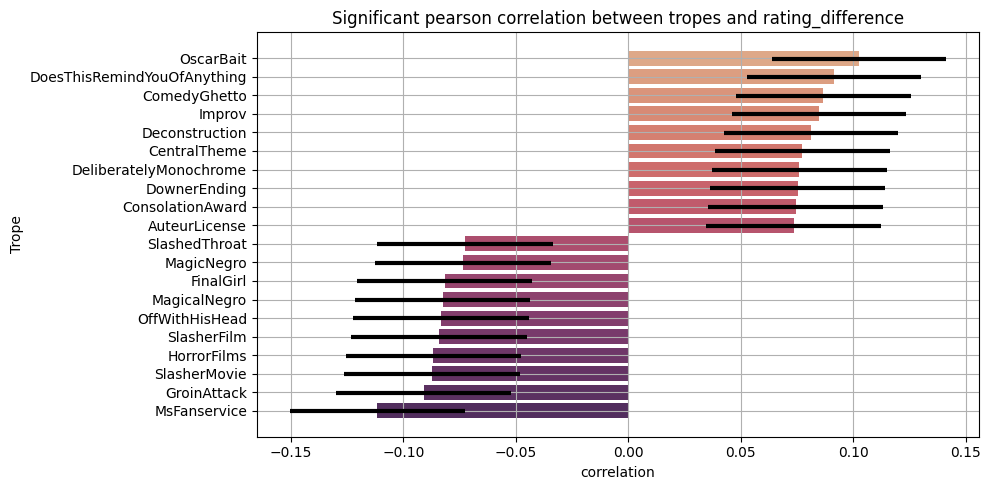

In [18]:
def map_tropes_columns(df):
    df['number_of_movies'] = df['col_id'].apply(lambda x: len(df_tropes[df_tropes['trope_id'] == x]))
    df['Trope'] = df['col_id'].apply(lambda x: df_tropes[df_tropes['trope_id'] == x]['trope'].iloc[0])

    return df

tropes_pearsonr_results, tropes_pearsonr_significant = study_pearson(
    one_hot_tropes,
    one_hot_tropes_columns,
    'rating_difference',
    colname='Trope',
    threshold=0.05,
    print_results=True,
    plot_barplot=True,
    map_columns_name=map_tropes_columns,
    title="Significant pearson correlation between tropes and rating_difference"
)

In [57]:
#export_json(tropes_pearsonr_results, 'website/public/data/tropes-1.json')

### Basic OLS

Dep. Variable:,rating_difference,R-squared:,0.977
Model:,OLS,Adj. R-squared:,0.144
Method:,Least Squares,F-statistic:,1.173
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,0.205
Time:,23:07:06,Log-Likelihood:,-5164.7
No. Observations:,2495,AIC:,1.519e+04
Df Residuals:,66,BIC:,2.933e+04
Df Model:,2428,,
Covariance Type:,nonrobust,,


Omnibus:,854.204,Durbin-Watson:,2.022
Prob(Omnibus):,0.000,Jarque-Bera (JB):,270625.050
Skew:,-0.014,Prob(JB):,0.00
Kurtosis:,54.022,Cond. No.,2.49e+16




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.977345,0.143916,0.347346,3.677355
baseline,0.0,0.0,10.325524,162.319886
improvement,inf,inf,-96.64%,-97.73%


Significant results: 125/2878

Top 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Trope
53,onehot-tropes_t11686,90.4812,0.000,42.651,138.311,t11686,22,InterserviceRivalry
0,onehot-tropes_t00159,76.3193,0.008,20.159,132.480,t00159,23,AcousticLicense
15,onehot-tropes_t04443,73.4211,0.009,18.586,128.256,t04443,22,CoolBoat
4,onehot-tropes_t00323,73.0889,0.019,12.354,133.824,t00323,45,AdoredByTheNetwork
19,onehot-tropes_t05415,72.7949,0.024,9.710,135.880,t05415,48,Defictionalization
76,onehot-tropes_t17365,71.6349,0.013,15.763,127.507,t17365,49,PopculturalOsmosis
108,onehot-tropes_t26676,66.8453,0.015,13.538,120.152,t26676,23,WhatMeasureIsANonCute
42,onehot-tropes_t10398,66.6846,0.016,12.809,120.560,t10398,24,HollywoodHacking
120,onehot-tropes_t29216,65.4433,0.027,7.521,123.365,t29216,32,SexEqualsDeath
8,onehot-tropes_t00856,65.0756,0.022,9.903,120.248,t00856,23,AnAssKickingChristmas



Bottom 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Trope
122,onehot-tropes_t30145,-64.9692,0.012,-115.437,-14.502,t30145,26,DoublemeaningTitle
39,onehot-tropes_t09810,-65.0911,0.001,-103.639,-26.544,t09810,37,HardWorkMontage
121,onehot-tropes_t29724,-65.6415,0.004,-109.661,-21.622,t29724,25,InterGenerationalFriendship
77,onehot-tropes_t17431,-66.2301,0.024,-123.444,-9.017,t17431,23,PostClimaxConfrontation
105,onehot-tropes_t26208,-67.3441,0.007,-115.287,-19.401,t26208,32,WordSequel
41,onehot-tropes_t10325,-70.7231,0.023,-131.267,-10.179,t10325,21,HitMeDammit
66,onehot-tropes_t14501,-72.1435,0.013,-128.325,-15.962,t14501,27,MoodMotif
111,onehot-tropes_t26756,-73.0849,0.032,-139.585,-6.584,t26756,38,IllKillYou
101,onehot-tropes_t25913,-74.8703,0.007,-128.325,-21.416,t25913,23,WhenYouComingHomeDad
116,onehot-tropes_t27603,-94.4453,0.008,-163.845,-25.045,t27603,20,SparedByAdaptation


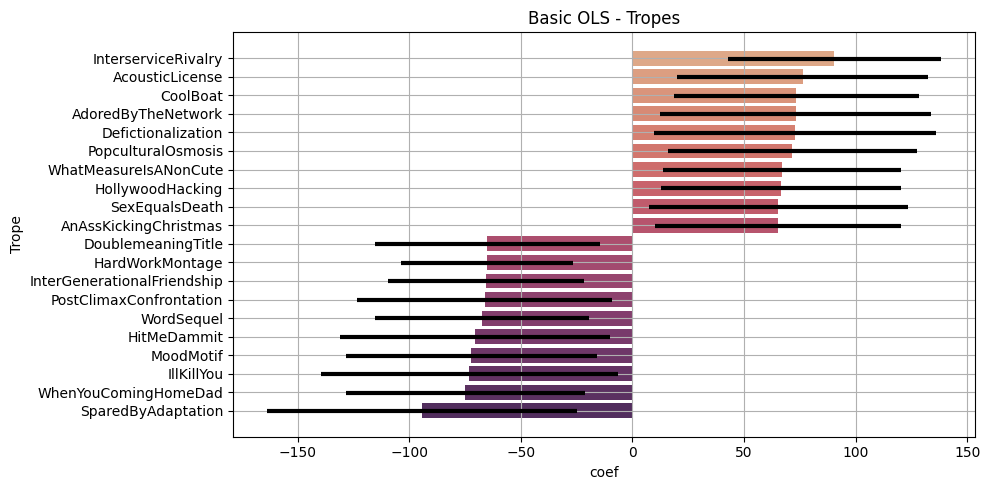

In [19]:
# Fit OLS
def map_tropes_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_tropes[df_tropes['trope_id'] == x]))
    df['Trope'] = df['col_id'].map(lambda x: df_tropes[df_tropes['trope_id'] == x]['trope'].iloc[0])

    return df

tropes_basic_ols_results, tropes_basic_ols_significant = study_OLS(
    one_hot_tropes,
    one_hot_tropes_columns,
    'rating_difference',
    colname='Trope',
    regularization=None,
    alpha=0.001,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    map_columns_name=map_tropes_columns,
    title='Basic OLS - Tropes'
)

### VIF (Variance Inflation Factor) Filtering

In [20]:
tropes_vif_significant = filter_VIF(one_hot_tropes, tropes_pearsonr_significant, threshold=5)

print(f'Number of columns after VIF filtering: {len(tropes_vif_significant)}/{len(tropes_pearsonr_significant)}')

 33%|███▎      | 110/336 [00:54<01:53,  1.99it/s]c:\Users\anton\Documents\MA3\ada-2023-project-radatouille\.venv\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
100%|██████████| 336/336 [02:46<00:00,  2.01it/s]

Number of columns after VIF filtering: 315/336


### Final OLS

Dep. Variable:,rating_difference,R-squared:,0.301
Model:,OLS,Adj. R-squared:,0.200
Method:,Least Squares,F-statistic:,2.982
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,1.21e-48
Time:,23:10:00,Log-Likelihood:,-9442.4
No. Observations:,2495,AIC:,1.952e+04
Df Residuals:,2179,BIC:,2.136e+04
Df Model:,315,,
Covariance Type:,nonrobust,,


Omnibus:,5.009,Durbin-Watson:,1.891
Prob(Omnibus):,0.082,Jarque-Bera (JB):,4.963
Skew:,-0.108,Prob(JB):,0.0836
Kurtosis:,3.028,Cond. No.,34.5




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.301207,0.200188,8.458117,113.428006
baseline,0.0,0.0,10.325524,162.319886
improvement,inf,inf,-18.09%,-30.12%


Significant results: 36/315

Top 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Trope
6,onehot-tropes_t15220,7.9612,0.009,2.004,13.919,t15220,22,NewOldWest
13,onehot-tropes_t26887,7.2026,0.036,0.485,13.920,t26887,21,RoofHopping
9,onehot-tropes_t26033,6.9096,0.010,1.666,12.153,t26033,23,WidgetSeries
3,onehot-tropes_t12717,6.8900,0.004,2.162,11.618,t12717,31,LeFilmArtistique
5,onehot-tropes_t14187,6.5798,0.018,1.139,12.021,t14187,29,MinionWithAnFInEvil
8,onehot-tropes_t20057,6.3058,0.014,1.256,11.355,t20057,27,SharpDressedMan
10,onehot-tropes_t19955,6.1087,0.048,0.056,12.161,t19955,23,SexlessMarriage
11,onehot-tropes_t02848,5.8854,0.040,0.268,11.502,t02848,27,BrieferThanTheyThink
7,onehot-tropes_t23411,5.8538,0.002,2.115,9.593,t23411,58,TheRemake
1,onehot-tropes_t11242,5.0445,0.046,0.082,10.007,t11242,38,Improv



Bottom 10:


,feature,coef,p_value,lower_ci,upper_ci,col_id,number_of_movies,Trope
22,onehot-tropes_t19457,-6.1736,0.016,-11.188,-1.159,t19457,29,SchmuckBait
14,onehot-tropes_t24965,-6.4509,0.009,-11.289,-1.612,t24965,28,UnsympatheticComedyProtagonist
32,onehot-tropes_t05250,-7.1971,0.011,-12.763,-1.632,t05250,31,DeanBitterman
29,onehot-tropes_t16505,-7.2529,0.012,-12.889,-1.617,t16505,25,OutWithABang
33,onehot-tropes_t13503,-7.3717,0.028,-13.958,-0.785,t13503,55,MagicalNegro
19,onehot-tropes_t22523,-7.5656,0.029,-14.353,-0.778,t22523,21,ThanatosGambit
31,onehot-tropes_t08179,-7.6544,0.021,-14.148,-1.161,t08179,21,FlashedBadgeHijack
27,onehot-tropes_t15811,-8.0571,0.017,-14.699,-1.415,t15811,20,NumberOfTheBeast
23,onehot-tropes_t04789,-9.3525,0.027,-17.640,-1.065,t04789,23,CrooksAreBetterArmed
17,onehot-tropes_t09662,-11.7783,0.000,-18.004,-5.552,t09662,22,HaHaHaNo


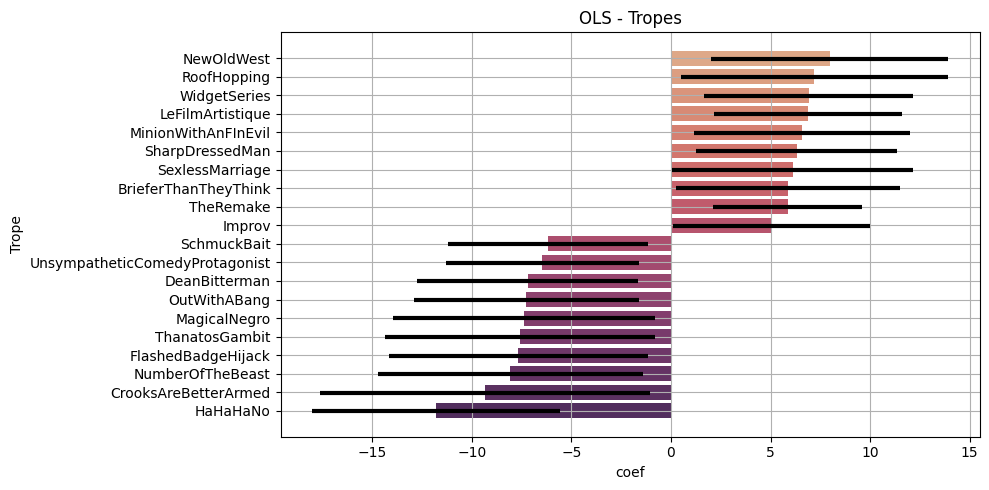

In [21]:
# Fit OLS
def map_tropes_columns(df):
    df['number_of_movies'] = df['col_id'].map(lambda x: len(df_tropes[df_tropes['trope_id'] == x]))
    df['Trope'] = df['col_id'].map(lambda x: df_tropes[df_tropes['trope_id'] == x]['trope'].iloc[0])

    return df

tropes_ols_results, tropes_ols_significant = study_OLS(
    one_hot_tropes,
    tropes_vif_significant,
    'rating_difference',
    colname='Trope',
    regularization='l1',
    alpha=0.001,
    threshold=0.05,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    map_columns_name=map_tropes_columns,
    title='OLS - Tropes'
)

In [61]:
#export_json(tropes_ols_results, 'website/public/data/tropes-2.json')

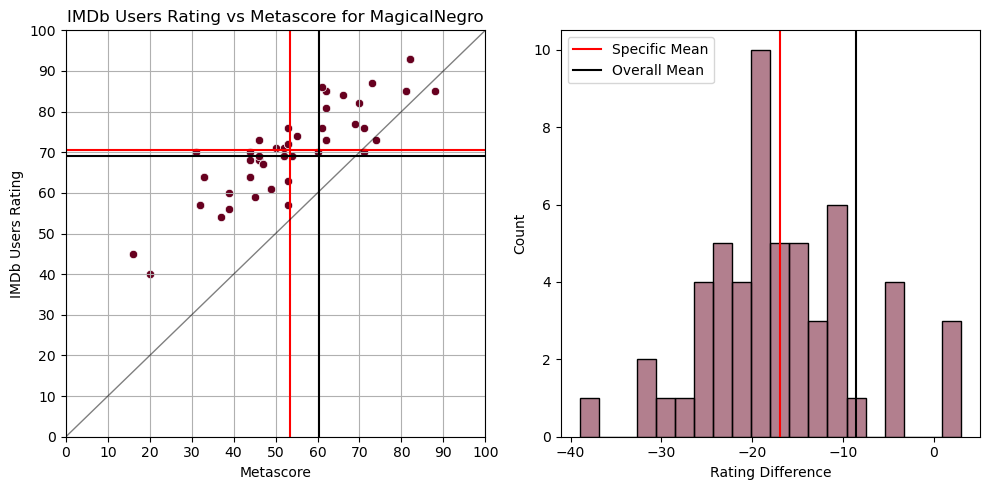

In [62]:
plot_specific_scatter(
    df_tropes.merge(data[['imdb_id', 'imdb_rating_scaled', 'metascore', 'rating_difference']], on='imdb_id'),
    'trope',
    'MagicalNegro'
    )

In [22]:
def output_playground_genres(path):
    merged_df = df_tropes[df_tropes['trope'].isin(tropes_ols_results['Trope'])] \
        .merge(tropes_ols_results, left_on='trope', right_on='Trope') \
        .groupby('trope') \
        .apply(lambda x: {'ids': x['imdb_id'].tolist(), 'ols_coefficient': x['coef'].iloc[0]}) \
        .to_json(path)

In [24]:
output_playground_genres('website/public/data/playground-tropes.json')

In [63]:
# save all imdb_ids per trope
df_tropes \
    .loc[df_tropes['trope'].isin(tropes_ols_results['Trope'])]  \
    .groupby('trope') \
    .apply(lambda x: x['imdb_id'].tolist()) \
    .to_json('website/public/data/playground-tropes.json')


# Conclusion

### Preprocessing

In [64]:
# Genres
one_hot_movies_genres, one_hot_movies_genres_columns  = hotencode(df_genres, 'genres', id_column='freebase_id', prefix='onehot-genre')

# Actors
df_actors = process_actors(data_characters, movies_threshold=6)
one_hot_actors, one_hot_actors_columns = hotencode(df_actors, 'freebase_actor_id', id_column='freebase_id', prefix='onehot-actor')

# Countries
one_hot_countries, one_hot_countries_columns = hotencode(df_countries, 'countries', id_column='freebase_id', prefix='onehot-country')

# Tropes
one_hot_tropes, one_hot_tropes_columns = hotencode(df_tropes, 'trope_id', id_column='imdb_id', prefix='onehot-tropes')
one_hot_tropes = one_hot_tropes.merge(data[['imdb_id', 'freebase_id']].drop_duplicates(), on='imdb_id').drop(columns=['imdb_id'])

# Release Date
df_release_date = data.copy()
df_release_date['release_date_datetime'] = pd.to_datetime(df_release_date['release_date_datetime'])
df_release_date['year'] = df_release_date['release_date_datetime'].dt.year
df_release_date = df_release_date.dropna(subset=['year'])
df_release_date = df_release_date[['freebase_id', 'year']]
# Normalize the year
scaler = MinMaxScaler()
df_release_date['year'] = scaler.fit_transform(df_release_date[['year']])



# Runtime
df_runtime = data.copy()
df_runtime.dropna(subset=['runtime'], inplace=True)
df_runtime = df_runtime[['freebase_id', 'runtime']]
# Normalize the runtime
scaler = MinMaxScaler()
df_runtime['runtime'] = scaler.fit_transform(df_runtime[['runtime']])


### Merge Global OLS significance

In [65]:
print(f"Countries OLS significant features: {len(countries_ols_significant)}")
print(f"Genres OLS significant features: {len(genres_ols_significant)}")
print(f"Actors OLS significant features: {len(actors_ols_significant)}")
print(f"Tropes OLS significant features: {len(tropes_ols_significant)}")

Countries OLS significant features: 6
Genres OLS significant features: 22
Actors OLS significant features: 20
Tropes OLS significant features: 37


In [66]:
# Keep only the significant columns
one_hot_movies_genres_ols_significant = one_hot_movies_genres[genres_ols_significant + ['freebase_id']]
one_hot_actors_ols_significant = one_hot_actors[list(set(one_hot_actors.columns.to_list()) & set(actors_ols_significant) ) + ['freebase_id']]
one_hot_countries_ols_significant = one_hot_countries[countries_ols_significant + ['freebase_id']]
one_hot_tropes_ols_significant = one_hot_tropes[tropes_ols_significant + ['freebase_id']]

global_ols_significant_columns = list(set(genres_ols_significant + list(set(one_hot_actors.columns.to_list()) & set(actors_ols_significant)) + countries_ols_significant + tropes_ols_significant + ['runtime', 'year']))

print(f"Global OLS significant features: {len(global_ols_significant_columns)}")

Global OLS significant features: 87


In [67]:
# Merge all the dataframes
one_hot_global_ols_significant = one_hot_movies_genres_ols_significant.merge(one_hot_actors_ols_significant, on='freebase_id', how='left')
one_hot_global_ols_significant = one_hot_global_ols_significant.merge(one_hot_countries_ols_significant, on='freebase_id', how='left')
one_hot_global_ols_significant = one_hot_global_ols_significant.merge(one_hot_tropes_ols_significant, on='freebase_id', how='left')
one_hot_global_ols_significant = one_hot_global_ols_significant.merge(data[['freebase_id', 'rating_difference']].drop_duplicates(), on='freebase_id')
one_hot_global_ols_significant = one_hot_global_ols_significant.merge(df_release_date, on='freebase_id', how='left')
one_hot_global_ols_significant = one_hot_global_ols_significant.merge(df_runtime, on='freebase_id', how='left')

print("Shape of the one hot encoded dataframe:", one_hot_global_ols_significant.shape)

# Filter rows with NaN values
one_hot_global_ols_significant = one_hot_global_ols_significant.dropna()

print("Shape of the one hot encoded dataframe after dropping NaN values:", one_hot_global_ols_significant.shape)


Shape of the one hot encoded dataframe: (7770, 89)
Shape of the one hot encoded dataframe after dropping NaN values: (2202, 89)


### Pearson Correlation

Significant results: 66/87

Top 10:


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


,correlation,p_value,lower_ci,upper_ci,feature,col_id,Feature
onehot-genre_Drama,0.215183,1.757665e-24,0.174984,0.254666,onehot-genre_Drama,Drama,Genre - Drama
onehot-genre_Black-and-white,0.179376,2.225154e-17,0.138643,0.219503,onehot-genre_Black-and-white,Black-and-white,Genre - Black-and-white
onehot-genre_World cinema,0.121693,1.012860e-08,0.080330,0.162638,onehot-genre_World cinema,World cinema,Genre - World cinema
runtime,0.103357,1.171770e-06,0.061852,0.144505,runtime,runtime,runtime
onehot-genre_New Hollywood,0.100275,2.420930e-06,0.058750,0.141454,onehot-genre_New Hollywood,New Hollywood,Genre - New Hollywood
onehot-tropes_t05943,0.099158,3.133487e-06,0.057625,0.140348,onehot-tropes_t05943,t05943,Trope - DoesThisRemindYouOfAnything
onehot-genre_Film noir,0.097074,5.031963e-06,0.055528,0.138285,onehot-genre_Film noir,Film noir,Genre - Film noir
onehot-genre_Art film,0.096136,6.208563e-06,0.054584,0.137357,onehot-genre_Art film,Art film,Genre - Art film
onehot-actor_/m/02hfsd,0.087736,3.745458e-05,0.046133,0.129034,onehot-actor_/m/02hfsd,/m/02hfsd,Actor - Ward Bond
onehot-actor_/m/0p8r1,0.084199,7.626372e-05,0.042577,0.125529,onehot-actor_/m/0p8r1,/m/0p8r1,Actor - John Ratzenberger



Bottom 10:


,correlation,p_value,lower_ci,upper_ci,feature,col_id,Feature
onehot-actor_/m/038rzr,-0.070591,9.171851e-04,-0.112032,-0.028904,onehot-actor_/m/038rzr,/m/038rzr,Actor - Gerard Butler
onehot-tropes_t08179,-0.070766,8.905677e-04,-0.112206,-0.029080,onehot-tropes_t08179,t08179,Trope - FlashedBadgeHijack
onehot-tropes_t13503,-0.084274,7.514380e-05,-0.125603,-0.042652,onehot-tropes_t13503,t13503,Trope - MagicalNegro
onehot-genre_Slasher,-0.091871,1.575952e-05,-0.133132,-0.050293,onehot-genre_Slasher,Slasher,Genre - Slasher
onehot-genre_Teen,-0.107918,3.853369e-07,-0.149018,-0.066446,onehot-genre_Teen,Teen,Genre - Teen
onehot-tropes_t14656,-0.112085,1.340102e-07,-0.153140,-0.070644,onehot-tropes_t14656,t14656,Trope - MsFanservice
onehot-genre_Action,-0.123946,5.364885e-09,-0.164864,-0.082602,onehot-genre_Action,Action,Genre - Action
onehot-genre_Slapstick,-0.130930,6.958004e-10,-0.171763,-0.089649,onehot-genre_Slapstick,Slapstick,Genre - Slapstick
onehot-country_United States of America,-0.186378,1.162140e-18,-0.226388,-0.145741,onehot-country_United States of America,United States of America,Country - United States of America
year,-0.198840,4.528728e-21,-0.238630,-0.158384,year,year,year


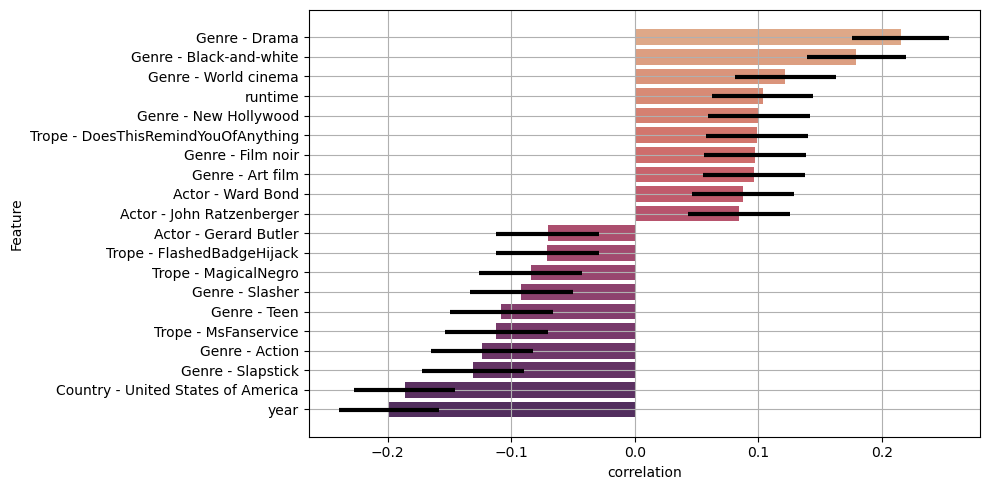

In [68]:
def map_global_columns(df):
    # if col_id empty set value of the feature column
    df['col_id'] = df['col_id'].apply(lambda x: x if x != '' else None)
    df['col_id'] = df['col_id'].fillna(df['feature'])

    df['Feature'] = df['feature'].apply(lambda x: ('Actor - ' + df_actors.loc[df_actors['freebase_actor_id'] == x.split('onehot-actor_')[1], 'actor_name'].iloc[0]) if 'actor' in x.split('_')[0] else
        'Country - ' + x.split('_')[1] if 'country' in x.split('_')[0] else
        'Genre - ' + x.split('_')[1] if 'genre' in x.split('_')[0]  else
        'Trope - ' + df_tropes.loc[df_tropes['trope_id'] == x.split('onehot-tropes_')[1], 'trope'].iloc[0] if 'tropes' in x.split('_')[0] else 
        x
    )

    return df

global_pearsonr_results, global_pearsonr_significant = study_pearson(one_hot_global_ols_significant, global_ols_significant_columns, 'rating_difference', colname="Feature", print_results=True, map_columns_name=map_global_columns)

In [69]:
#export_json(global_pearsonr_results, 'website/public/data/global-1.json')

### Basic OLS

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.280
Model:,OLS,Adj. R-squared:,0.251
Method:,Least Squares,F-statistic:,9.688
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,4.13e-99
Time:,16:37:19,Log-Likelihood:,-8349.2
No. Observations:,2202,AIC:,1.687e+04
Df Residuals:,2116,BIC:,1.736e+04
Df Model:,85,,
Covariance Type:,nonrobust,,


Omnibus:,20.619,Durbin-Watson:,1.880
Prob(Omnibus):,0.000,Jarque-Bera (JB):,21.002
Skew:,-0.227,Prob(JB):,2.75e-05
Kurtosis:,3.151,Cond. No.,nan




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.280145,0.251229,8.580442,115.057225
baseline,0.0,0.0,10.263981,159.833943
improvement,inf,inf,-16.4%,-28.01%


Significant results: 14/87


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


,feature,coef,p_value,lower_ci,upper_ci,col_id,Feature
9,onehot-genre_Black-and-white,9.0304,0.000,4.675,13.386,Black-and-white,Genre - Black-and-white
1,onehot-tropes_t11242,7.7405,0.001,3.204,12.277,t11242,Trope - Improv
10,onehot-tropes_t14187,7.1849,0.002,2.648,11.722,t14187,Trope - MinionWithAnFInEvil
0,onehot-genre_Comedy of manners,5.7334,0.000,2.566,8.901,Comedy of manners,Genre - Comedy of manners
5,onehot-tropes_t06991,5.4462,0.004,1.757,9.136,t06991,Trope - EventTitle
4,onehot-tropes_t05943,5.3829,0.000,3.129,7.637,t05943,Trope - DoesThisRemindYouOfAnything
7,onehot-genre_Drama,4.0682,0.000,2.932,5.204,Drama,Genre - Drama
8,onehot-genre_Action,-2.1781,0.000,-3.367,-0.989,Action,Genre - Action
2,onehot-genre_Crime Thriller,-2.6688,0.003,-4.425,-0.912,Crime Thriller,Genre - Crime Thriller
12,onehot-tropes_t14656,-3.1557,0.002,-5.128,-1.183,t14656,Trope - MsFanservice


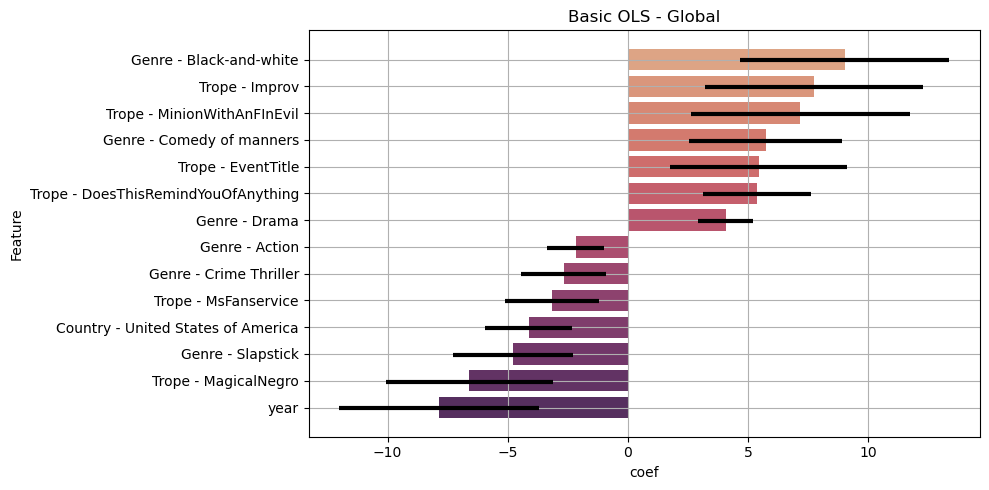

In [70]:
# Fit ols
def map_global_columns(df):
    df['Feature'] = df['feature'].apply(lambda x: ('Actor - ' + df_actors.loc[df_actors['freebase_actor_id'] == x.split('onehot-actor_')[1], 'actor_name'].iloc[0]) if 'actor' in x.split('_')[0] else
        'Country - ' + x.split('_')[1] if 'country' in x.split('_')[0] else
        'Genre - ' + x.split('_')[1] if 'genre' in x.split('_')[0]  else
        'Trope - ' + df_tropes.loc[df_tropes['trope_id'] == x.split('onehot-tropes_')[1], 'trope'].iloc[0] if 'tropes' in x.split('_')[0] else 
        x
    )

    
    return df

global_ols_results, global_ols_significant = study_OLS(
    one_hot_global_ols_significant,
    global_ols_significant_columns,
    'rating_difference',
    colname='Feature',
    regularization='l1',
    alpha=0.01,
    threshold=0.005,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    map_columns_name=map_global_columns,
    title='Basic OLS - Global'
)

### VIF (Variance Inflation Factor) Filtering

In [71]:
global_vif_significant = filter_VIF(one_hot_global_ols_significant, global_ols_significant_columns, threshold=5)

print(f'Number of columns after VIF filtering: {len(global_vif_significant)}/{len(global_ols_significant_columns)}')

# Print features that were removed by VIF
print(f"Features removed by VIF: {list(set(global_ols_significant_columns) - set(global_vif_significant))}")

  0%|          | 0/87 [00:00<?, ?it/s]

 64%|██████▍   | 56/87 [00:01<00:00, 51.57it/s]/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
100%|██████████| 87/87 [00:02<00:00, 38.93it/s]

Number of columns after VIF filtering: 82/87
Features removed by VIF: ['onehot-actor_/m/0668qk', 'onehot-country_Iran', 'runtime', 'year', 'onehot-country_United States of America']


### Final OLS

/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


Dep. Variable:,rating_difference,R-squared:,0.259
Model:,OLS,Adj. R-squared:,0.231
Method:,Least Squares,F-statistic:,9.052
Date:,"Tue, 19 Dec 2023",Prob (F-statistic):,7.09e-89
Time:,16:37:22,Log-Likelihood:,-8380.5
No. Observations:,2202,AIC:,1.693e+04
Df Residuals:,2119,BIC:,1.740e+04
Df Model:,82,,
Covariance Type:,nonrobust,,


Omnibus:,16.758,Durbin-Watson:,1.876
Prob(Omnibus):,0.000,Jarque-Bera (JB):,16.935
Skew:,-0.205,Prob(JB):,0.000210
Kurtosis:,3.125,Cond. No.,66.7




-- Baseline Comparaison --


,r2,r2-adj,mae,mse
model,0.25941,0.230751,8.717058,118.371455
baseline,0.0,0.0,10.263981,159.833943
improvement,inf,inf,-15.07%,-25.94%


Significant results: 15/82


/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:454: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  params_data = lzip([forg(params[i], prec=4) for i in exog_idx],
/Users/enzo/anaconda3/envs/ada/lib/python3.9/site-packages/statsmodels/iolib/summary.py:456: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [forg(tvalues[i]) for i in exog_idx],


,feature,coef,p_value,lower_ci,upper_ci,col_id,Feature
11,onehot-genre_Black-and-white,11.3084,0.000,7.033,15.584,Black-and-white,Genre - Black-and-white
2,onehot-tropes_t11242,8.3648,0.000,3.772,12.957,t11242,Trope - Improv
12,onehot-tropes_t14187,7.2149,0.002,2.617,11.812,t14187,Trope - MinionWithAnFInEvil
1,onehot-genre_New Hollywood,6.9743,0.001,2.836,11.113,New Hollywood,Genre - New Hollywood
0,onehot-genre_Comedy of manners,5.7595,0.000,2.550,8.969,Comedy of manners,Genre - Comedy of manners
8,onehot-tropes_t06991,5.4975,0.004,1.762,9.232,t06991,Trope - EventTitle
7,onehot-tropes_t05943,5.0909,0.000,2.808,7.374,t05943,Trope - DoesThisRemindYouOfAnything
9,onehot-genre_Drama,3.8596,0.000,2.751,4.968,Drama,Genre - Drama
3,onehot-genre_World cinema,3.5446,0.001,1.468,5.622,World cinema,Genre - World cinema
10,onehot-genre_Action,-2.5710,0.000,-3.771,-1.370,Action,Genre - Action


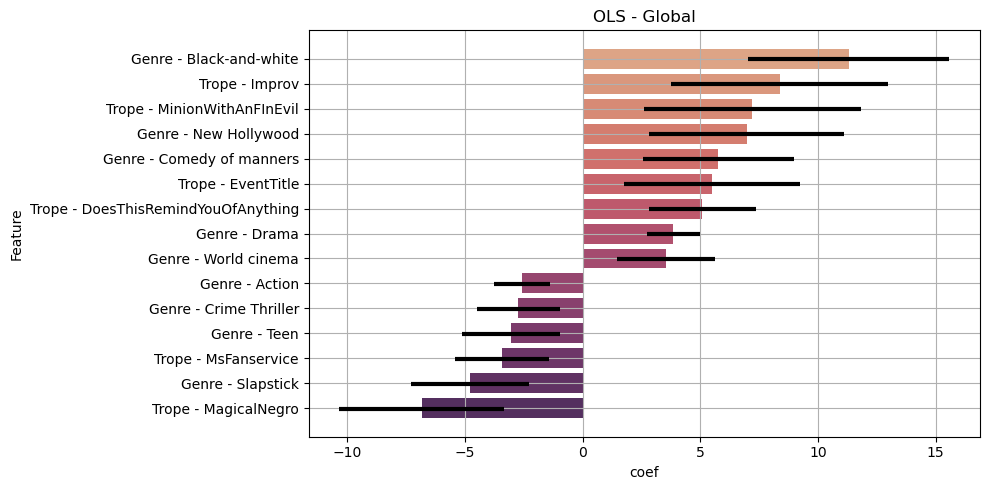

In [72]:
global_ols_results, global_ols_significant = study_OLS(
    one_hot_global_ols_significant,
    global_vif_significant,
    'rating_difference',
    colname='Feature',
    regularization='l1',
    alpha=0.01,
    threshold=0.005,
    print_results=True,
    print_qq=False,
    print_baseline=True,
    map_columns_name=map_global_columns,
    title='OLS - Global'
)

In [73]:
#export_json(global_ols_results, 'website/public/data/global-2.json')